<center>
    <h1> INF477 - Redes Neuronales Artificiales  </h1>
    <h2> Tarea #2 - Parte I: Entrenamiento de Autoencoders (AEs) y RBMs en MNIST </h2> 
</center>

Tarea realizada por:
* Alvaro Salinas - `alvaro.salinase@gmail.com` - **rol:** 201073001-8
* Martín Villanueva - `martin.villanueva@alumnos.usm.cl` - **rol:** 201104012-0

_DI UTFSM. Septiembre 2016._

## Tabla de Contenidos
* [1.0 Helper](#helper)
    * [Parte (a)](#1.0a)
* [1.1 Reducción de dimensionalidad](#dim)
    * [Parte (a)](#1.1a)
    * [Parte (b)](#1.1b)
    * [Parte (c)](#1.1c)
    * [Parte (d)](#1.1d)
    * [Parte (e)](#1.1e)
    * [Parte (f)](#1.1f)
    * [Parte (g)](#1.1g)
    * [Parte (h)](#1.1h)
    * [Parte (i)](#1.1i)
    * [Parte (j)](#1.1j)
* [1.2 Denoising](#den)
    * [Parte (a)](#1.2a)
    * [Parte (b)](#1.2b)
    * [Parte (c)](#1.2c)
    * [Parte (d)](#1.2d)
    * [Parte (e)](#1.2e)
    * [Parte (f)](#1.2f)
    * [Parte (g)](#1.2g)
* [1.3 Pre-entrenamiento](#pretr)
    * [Parte (a)](#1.3a)
    * [Parte (b)](#1.3b)
    * [Parte (c)](#1.3c)
    * [Parte (d)](#1.3d)
    * [Parte (e)](#1.3e)
    * [Parte (f)](#1.3f)
    * [Parte (g)](#1.3g)
    * [Parte (h)](#1.3h)

In [1]:
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

from keras_helper import load_keras_model as load

from keras.datasets import mnist
from keras.utils import np_utils
from keras.layers import Input, Dense
from keras.models import Model, load_model, save_model, Sequential
from keras.optimizers import SGD
from keras.objectives import binary_crossentropy
from keras.regularizers import l2

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.neural_network import BernoulliRBM
from sklearn.manifold import TSNE

Using Theano backend.


<div id='helper'/>
## 1.0 - Helper

<div id='1.0a'/>
### Parte (a)

A continuación se presenta la función de carga de datos solicitada, junto con otras funciones de ayuda (visualización) utilizadas en esta parte de la tarea.

In [4]:
def load_helper(nval=1000):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    # 0-1 scaling
    X_train = X_train.astype('float32') / 255.
    X_test = X_test.astype('float32') / 255.
    # reshaping
    X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
    X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
    # training / validation split
    X_val = X_train[-nval:]
    y_val = y_train[-nval:]
    X_train = X_train[:-nval]
    y_train = y_train[:-nval]
    # correct format
    y_train = np_utils.to_categorical(y_train, 10)
    y_val = np_utils.to_categorical(y_val, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    return X_train, X_val, X_test, y_train, y_val, y_test


def show_results(data_dict, x_axis, title=None, xlabel=None, ylabel=None, loc=1):
    fig = plt.figure(figsize=(10,5))
    ax = fig.gca()
    ax.set_xticks(x_axis)
    plt.xlim(x_axis[0]-0.1, x_axis[-1]+0.1)
    if title is not None: plt.title(title)
    for label,data in data_dict.items():
        plt.plot(x_axis, data, 'o-', label=label)
    plt.legend(loc=loc)
    if xlabel is not None: plt.xlabel(xlabel)
    if ylabel is not None: plt.ylabel(ylabel)
    plt.grid()
    plt.show()

In [5]:
### LOADING DATA
X_train, X_val, X_test, y_train, y_val, y_test = load_helper()

<div id='dim'/>
## 1.1 - Reducción de Dimensionalidad

<div id='1.1a'/>
### Parte (a)

Se provee a continuación una función genérica para el entrenamiento de AE básicos (con una sóla capa escondida). 

In [16]:
def train_basic_ae(X_train, X_val, hidden_size=32, activation1='sigmoid', activation2='sigmoid'):
    input_img = Input(shape=(784,))
    encoded = Dense(hidden_size, activation=activation1)(input_img)
    decoded = Dense(784, activation=activation2)(encoded)
    # building encoder, decoder and autoencoder
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(hidden_size,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(X_train, X_train, nb_epoch=50, batch_size=25, shuffle=True, 
                    validation_data=(X_val, X_val), verbose=0)
    # saving results
    encoder.save('enc_{0}d_{1}.h5'.format(hidden_size, activation1))
    decoder.save('dec_{0}d_{1}.h5'.format(hidden_size, activation1))
    autoencoder.save('ae_{0}d_{1}.h5'.format(hidden_size, activation1))
    return encoder, decoder, autoencoder

#### Función de activación: `Sigmoidal` (En `encoder` y `decoder`)

In [ ]:
[enc_2d_sigmoid, dec_2d_sigmoid, ae_2d_sigmoid] = train_basic_ae(X_train, X_val, hidden_size=2)
[enc_8d_sigmoid, dec_8d_sigmoid, ae_8d_sigmoid] = train_basic_ae(X_train, X_val, hidden_size=8)
[enc_32d_sigmoid, dec_32d_sigmoid, ae_32d_sigmoid] = train_basic_ae(X_train, X_val, hidden_size=32)
[enc_64d_sigmoid, dec_64d_sigmoid, ae_64d_sigmoid] = train_basic_ae(X_train, X_val, hidden_size=64)

Se elige como error de reconstrucción el MSE (*Mean squared error*). Esto pues más adelante se requiere comparar los resultados con PCA, el cual no necesariamente mantiene sus predicciones en el intervalo $[0,1]$, vale decir, para hacer una comparación más justa.

In [65]:
# reconstruction error: MSE
def rec_err(X, X_pred):
    m,n = X.shape
    aux = ((X - X_pred)**2).sum(axis=1) / n
    return aux.sum() / m

In [92]:
print('Sigmoid + d=2')
print('Porcentaje de compresion: {0}%'.format(2./784 * 100))
err = rec_err(X_test, ae_2d_sigmoid.predict(X_test))
print('Error de reconstruccion: {0} \n'.format(err))

print('Sigmoid + d=8')
print('Porcentaje de compresion: {0}%'.format(8./784 * 100))
err = rec_err(X_test, ae_8d_sigmoid.predict(X_test))
print('Error de reconstruccion: {0} \n'.format(err))

print('Sigmoid + d=32')
print('Porcentaje de compresion: {0}%'.format(32./784 * 100))
err = rec_err(X_test, ae_32d_sigmoid.predict(X_test))
print('Error de reconstruccion: {0} \n'.format(err))

print('Sigmoid + d=64')
print('Porcentaje de compresion: {0}%'.format(64./784 * 100))
err = rec_err(X_test, ae_64d_sigmoid.predict(X_test))
print('Error de reconstruccion: {0}'.format(err))

Sigmoid + d=2
Porcentaje de compresion: 0.255102040816%
Error de reconstruccion: 0.0674703491211 

Sigmoid + d=8
Porcentaje de compresion: 1.02040816327%
Error de reconstruccion: 0.0674777709961 

Sigmoid + d=32
Porcentaje de compresion: 4.08163265306%
Error de reconstruccion: 0.0371436340332 

Sigmoid + d=64
Porcentaje de compresion: 8.16326530612%
Error de reconstruccion: 0.01936459198


#### Función de activación: `ReLU` (en `encoder`) y `Sigmoidal` (en `decoder`) 

In [ ]:
[enc_2d_relu, dec_2d_relu, ae_2d_relu] = train_basic_ae(X_train, X_val, hidden_size=2, activation1='relu')
[enc_8d_relu, dec_8d_relu, ae_8d_relu] = train_basic_ae(X_train, X_val, hidden_size=8, activation1='relu')
[enc_32d_relu, dec_32d_relu, ae_32d_relu] = train_basic_ae(X_train, X_val, hidden_size=32, activation1='relu')
[enc_64d_relu, dec_64d_relu, ae_64d_relu] = train_basic_ae(X_train, X_val, hidden_size=64, activation1='relu')

In [93]:
print('ReLU + d=2')
print('Porcentaje de compresion: {0}%'.format(2./784 * 100))
err = rec_err(X_test, ae_2d_relu.predict(X_test))
print('Error de reconstruccion: {0} \n'.format(err))

print('ReLU + d=8')
print('Porcentaje de compresion: {0}%'.format(8./784 * 100))
err = rec_err(X_test, ae_8d_relu.predict(X_test))
print('Error de reconstruccion: {0} \n'.format(err))

print('ReLU + d=32')
print('Porcentaje de compresion: {0}%'.format(32./784 * 100))
err = rec_err(X_test, ae_32d_relu.predict(X_test))
print('Error de reconstruccion: {0} \n'.format(err))

print('ReLU + d=64')
print('Porcentaje de compresion: {0}%'.format(64./784 * 100))
err = rec_err(X_test, ae_64d_relu.predict(X_test))
print('Error de reconstruccion: {0}'.format(err))

ReLU + d=2
Porcentaje de compresion: 0.255102040816%
Error de reconstruccion: 0.0557904296875 

ReLU + d=8
Porcentaje de compresion: 1.02040816327%
Error de reconstruccion: 0.0348007202148 

ReLU + d=32
Porcentaje de compresion: 4.08163265306%
Error de reconstruccion: 0.0100807395935 

ReLU + d=64
Porcentaje de compresion: 8.16326530612%
Error de reconstruccion: 0.0040022228241


In [5]:
# Almacenando resultados en listas
rec_err_ae_sigmoid = [0.0674703491211, 0.0674777709961, 0.0371436340332, 0.01936459198]
rec_err_ae_relu = [0.0557904296875, 0.0348007202148, 0.0100807395935, 0.0040022228241]

En el gráfico que se muestra a continuación se resumen los resultados de error de reconstrucción obtenidos. Para ambos casos (`sigmoid` y `relu`), la capacidad de reconstrucción aumenta con valores de `d` mayores. Por otro lado, se nota una mejora significativa al cambiar la función de activación por `relu`, indicando que tiene una mejor capacidad de representación en baja dimensionalidad. 

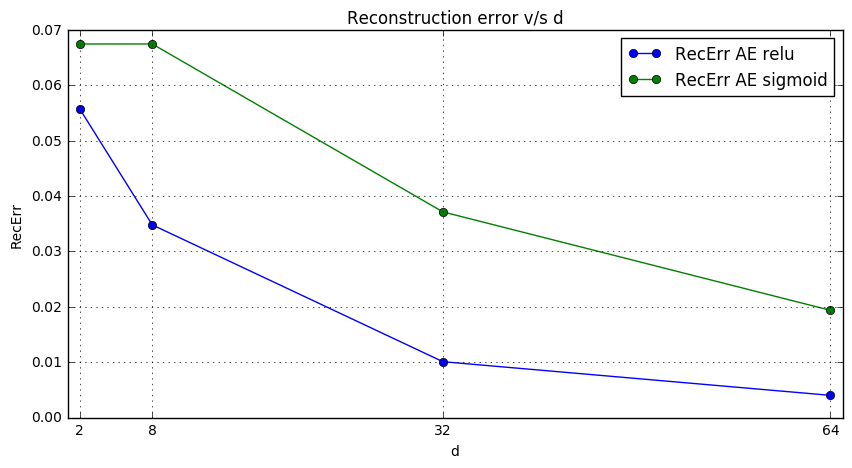

In [22]:
data_dict = {'RecErr AE sigmoid': rec_err_ae_sigmoid, 'RecErr AE relu':rec_err_ae_relu}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='RecErr', title='Reconstruction error v/s d')

**Nota:** No es posible ocupar en este caso una función de activación `ReLU` para el `decoder`, dado que esto da la posibilidad de obtener valores $\geq 1$ (Lo cual no es posible, pues la representación se definió de tal modo que los valores están en $[0,1]$).

<div id='1.1b'/>
### Parte (b)

In [56]:
def visualize_reconstruction(X_test, ae):
    decoded_test = ae.predict(X_test)
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

#### Encoder con `sigmoid` y `d=8`

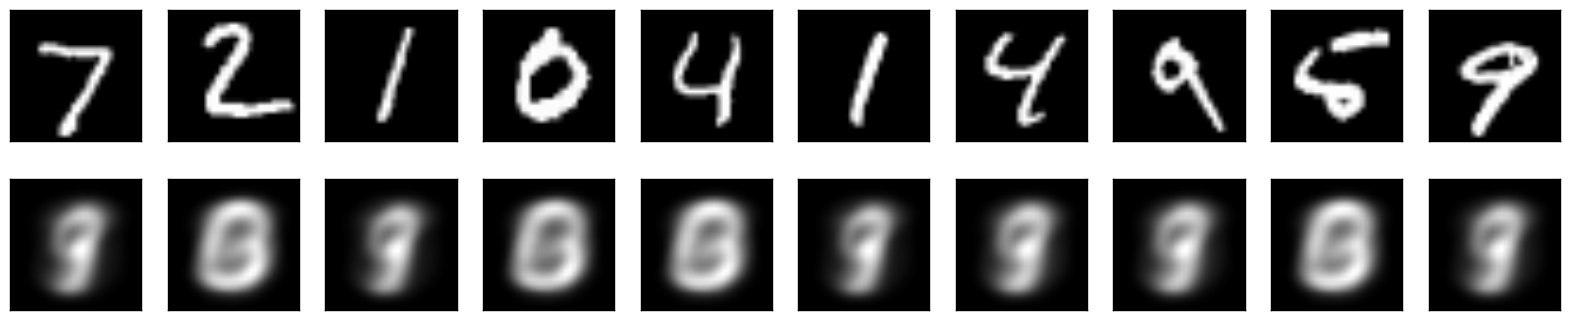

In [39]:
visualize_reconstruction(X_test, ae_8d_sigmoid)

#### Encoder con `sigmoid` y `d=64` 

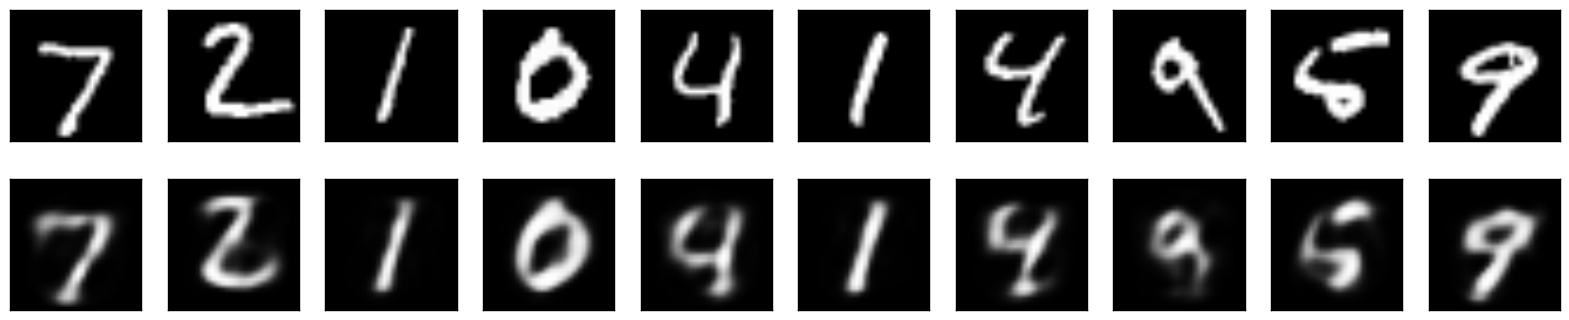

In [40]:
visualize_reconstruction(X_test, ae_64d_sigmoid)

#### Encoder con `relu` y `d=8`

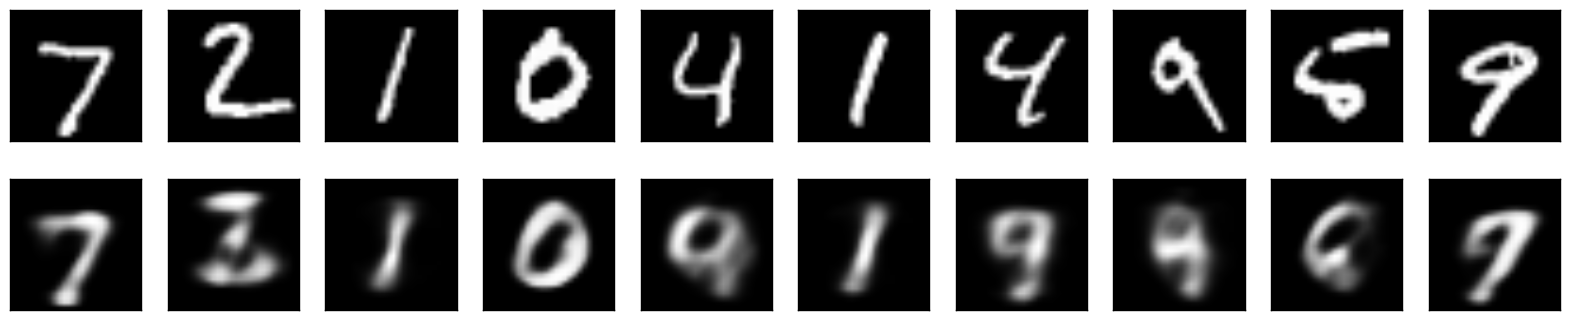

In [41]:
visualize_reconstruction(X_test, ae_8d_relu)

#### Encoder con `relu` y `d=64`

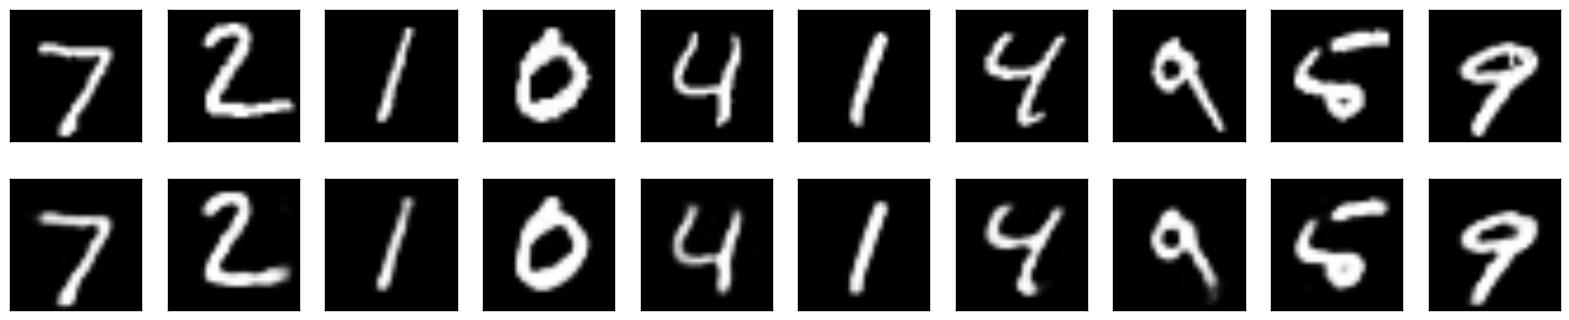

In [42]:
visualize_reconstruction(X_test, ae_64d_relu)

Se muestran los resultados para `d=8` y `d=64`. Los resultados visuales son acordes a los errores de reconstrucción obtenidos en la sección anterior. La capacidad de reconstrucción de el AE con `sigmoid` es limitada (se ve claramente en `d=8`), mientras que el AE con `relu` y `d=64` reconstruye casi perfectamente cada muestra.

<div id='1.1c'/>
### Parte (c)

In [17]:
def knn_classification_accuracy(X_train, y_train, X_test, y_test, verbose=1):
    clf = KNeighborsClassifier(10)
    t0 = time.time()
    clf.fit(X_train, y_train)
    elapsed = time.time()-t0
    score = clf.score(X_test, y_test)
    if verbose:
        print('Classification Accuracy: %.2f' % score)
        print('Elapsed time: {0}[s] \n'.format(elapsed))
    del clf
    return score

In [25]:
print('Sigmoid + d=2')
knn_classification_accuracy(enc_2d_sigmoid.predict(X_train), y_train, enc_2d_sigmoid.predict(X_test), y_test)

print('Sigmoid + d=8')
knn_classification_accuracy(enc_8d_sigmoid.predict(X_train), y_train, enc_8d_sigmoid.predict(X_test), y_test)

print('Sigmoid + d=32')
knn_classification_accuracy(enc_32d_sigmoid.predict(X_train), y_train, enc_32d_sigmoid.predict(X_test), y_test)

print('Sigmoid + d=64')
knn_classification_accuracy(enc_64d_sigmoid.predict(X_train), y_train, enc_64d_sigmoid.predict(X_test), y_test)

print('ReLU + d=2')
knn_classification_accuracy(enc_2d_relu.predict(X_train), y_train, enc_2d_relu.predict(X_test), y_test)

print('ReLU + d=8')
knn_classification_accuracy(enc_8d_relu.predict(X_train), y_train, enc_8d_relu.predict(X_test), y_test)

print('ReLU + d=32')
knn_classification_accuracy(enc_32d_relu.predict(X_train), y_train, enc_32d_relu.predict(X_test), y_test)

print('ReLU + d=64')
knn_classification_accuracy(enc_64d_relu.predict(X_train), y_train, enc_64d_relu.predict(X_test), y_test)

print('Original data (No reduction)')
knn_classification_accuracy(X_train, y_train, X_test, y_test)

Sigmoid + d=2
Classification Accuracy: 0.00
Elapsed time: 0.448776960373[s] 

Sigmoid + d=8
Classification Accuracy: 0.18
Elapsed time: 0.112163066864[s] 

Sigmoid + d=32
Classification Accuracy: 0.83
Elapsed time: 0.181217908859[s] 

Sigmoid + d=64
Classification Accuracy: 0.95
Elapsed time: 0.304636001587[s] 

ReLU + d=2
Classification Accuracy: 0.22
Elapsed time: 0.0647070407867[s] 

ReLU + d=8
Classification Accuracy: 0.86
Elapsed time: 0.0793220996857[s] 

ReLU + d=32
Classification Accuracy: 0.96
Elapsed time: 0.166414022446[s] 

ReLU + d=64
Classification Accuracy: 0.95
Elapsed time: 0.311235189438[s] 

Original data (No reduction)
Classification Accuracy: 0.96
Elapsed time: 18.7843770981[s] 



Respecto de los tiempo de entrenamiento del clasificador `kNN`, se ve que hay una reducción significativa al disminuir el reducir la dimensionalidad de la data. Esto de debe a que `kNN` es un algoritmo de complejidad $O(n^2)$, dado que requiere computar las distancias entre todos los ejemplos de entrenamiento.

In [8]:
# Almacenando resultados en listas
ca_ae_sigmoid = [0.00, 0.18, 0.83, 0.95]
ca_ae_relu = [0.22, 0.86, 0.96, 0.95]

En base al gráfico que se muestra a continuación, se verifica que la capacidad de clasificación que genera el AE con `relu` es superior a la obtenida con `sigmoid`. De forma natural, al aumentar el número de neuronas de la capa oculta, la capacidad de clasificación con las representaciones obtenidas es superior.

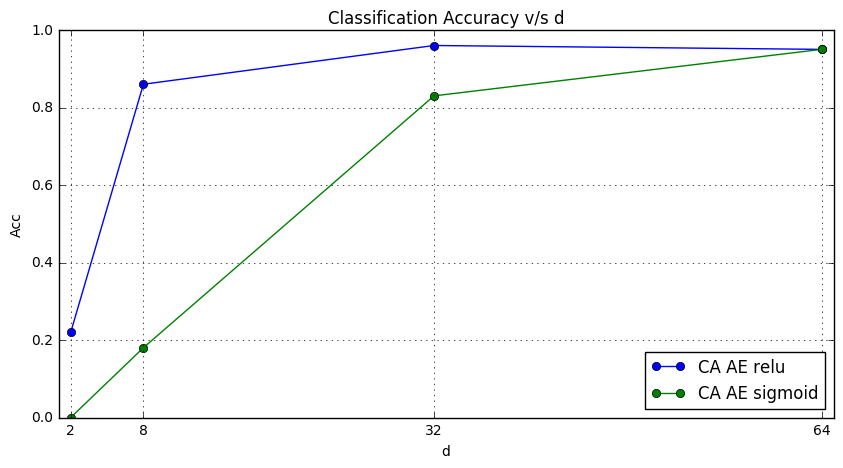

In [28]:
data_dict = {'CA AE sigmoid': ca_ae_sigmoid, 'CA AE relu':ca_ae_relu}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='Acc', title='Classification Accuracy v/s d', loc=4)

<div id='1.1d'/>
### Parte (d)

In [16]:
def clustering_accuracy(y, pred_labels, nclusters=10):
    true_pred = 0.0
    for i in range(0, nclusters):
        mvlabel = np.argmax(np.bincount(y[pred_labels==i]))
        true_pred += sum(y[pred_labels==i] == mvlabel)
    return true_pred/len(y)

def clustering_scores(X_train, y_train, verbose=1):
    y_train = np.argmax(y_train, axis=1)
    model = KMeans(n_clusters=10)
    labels_pred = model.fit_predict(X_train)
    ari = adjusted_rand_score(y_train, labels_pred)
    acc = clustering_accuracy(y_train, labels_pred)
    if verbose:
        print('Clustering ARI: {0}'.format(ari))
        print('Clustering ACC: {0} \n'.format(acc))
    del model
    return acc

In [42]:
print('Sigmoid + d=2')
clustering_scores(enc_2d_sigmoid.predict(X_train), y_train)

print('Sigmoid + d=8')
clustering_scores(enc_8d_sigmoid.predict(X_train), y_train)

print('Sigmoid + d=32')
clustering_scores(enc_32d_sigmoid.predict(X_train), y_train)

print('Sigmoid + d=64')
clustering_scores(enc_64d_sigmoid.predict(X_train), y_train)

print('ReLU + d=2')
clustering_scores(enc_2d_relu.predict(X_train), y_train)

print('ReLU + d=8')
clustering_scores(enc_8d_relu.predict(X_train), y_train)

print('ReLU + d=32')
clustering_scores(enc_32d_relu.predict(X_train), y_train)

print('ReLU + d=64')
clustering_scores(enc_64d_relu.predict(X_train), y_train)

print('Original data (No reduction)')
clustering_scores(X_train, y_train)

Sigmoid + d=2
Clustering ARI: 0.000272498252964
Clustering ACC: 0.119983050847 

Sigmoid + d=8
Clustering ARI: 0.000800324299906
Clustering ACC: 0.11813559322 

Sigmoid + d=32
Clustering ARI: 0.353451509837
Clustering ACC: 0.574966101695 

Sigmoid + d=64
Clustering ARI: 0.410933774352
Clustering ACC: 0.610050847458 

ReLU + d=2
Clustering ARI: 0.177531118763
Clustering ACC: 0.375813559322 

ReLU + d=8
Clustering ARI: 0.301972563823
Clustering ACC: 0.507186440678 

ReLU + d=32
Clustering ARI: 0.223556527212
Clustering ACC: 0.476542372881 

ReLU + d=64
Clustering ARI: 0.238850809743
Clustering ACC: 0.437288135593 

Original data (No reduction)
Clustering ARI: 0.360236626723
Clustering ACC: 0.590508474576 



In [10]:
# almacenando resultados en listas
ari_ae_sigmoid = [0.000272498252964, 0.000800324299906, 0.353451509837, 0.410933774352]
acc_ae_sigmoid = [0.119983050847, 0.11813559322, 0.574966101695, 0.610050847458]
ari_ae_relu = [0.177531118763, 0.301972563823, 0.223556527212, 0.238850809743]
acc_ae_relu = [0.375813559322, 0.507186440678, 0.476542372881, 0.437288135593]

Los dos gráficos siguientes resumen la capacidad de clusterización que proveen las representaciones aprendidas con los AEs. Se nota que en el caso del AE entrenado con `sigmoid`, cuando la reducción de dimensionalidad es significativa (`d=2` o `d=8`), genera resultados bastante malos. Por otro lado al aumentar `d`, el AE que se comporta mejor es el entrenado con `sigmoid`.

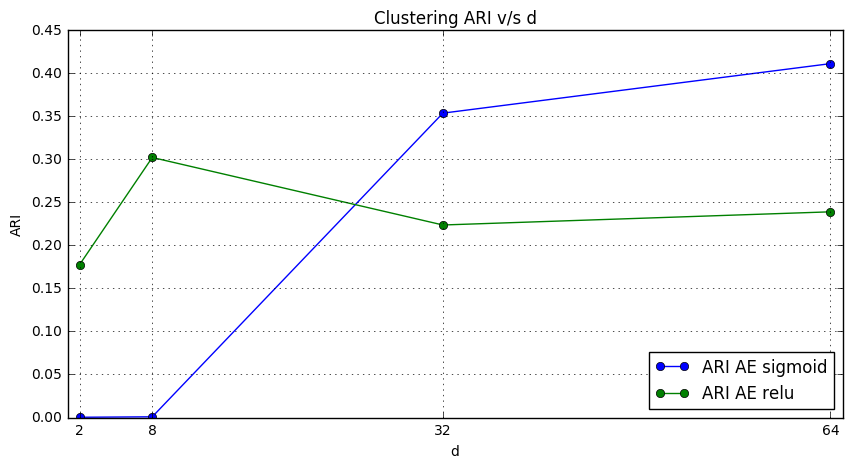

In [32]:
data_dict1 = {'ARI AE sigmoid': ari_ae_sigmoid, 'ARI AE relu':ari_ae_relu}
show_results(data_dict1, [2,8,32,64], xlabel='d', ylabel='ARI', title='Clustering ARI v/s d', loc=4)

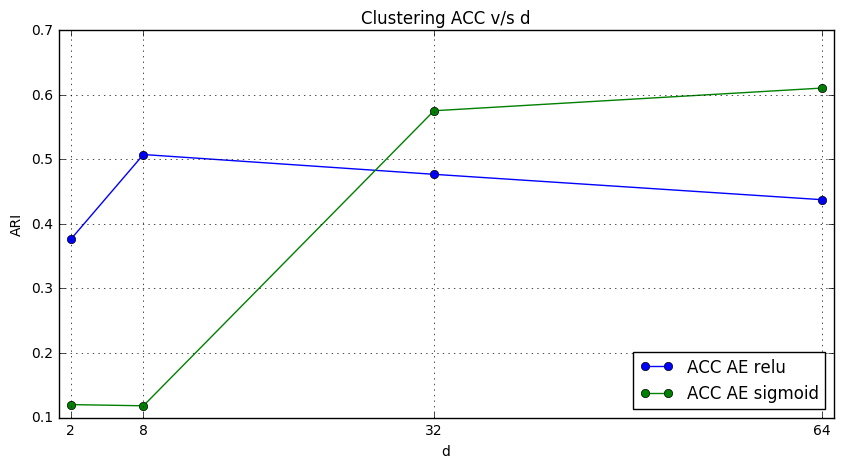

In [33]:
data_dict2 = {'ACC AE sigmoid': acc_ae_sigmoid, 'ACC AE relu':acc_ae_relu}
show_results(data_dict2, [2,8,32,64], xlabel='d', ylabel='ARI', title='Clustering ACC v/s d', loc=4)

<div id='1.1e'/>
### Parte (e)

In [12]:
def pca_reduction(X_train, X_test, d):
    pca = PCA(n_components=d)
    pca.fit(X_train)
    pca_train = pca.transform(X_train)
    pca_train_rec = pca.inverse_transform(pca_train)
    pca_test = pca.transform(X_test)
    pca_test_rec = pca.inverse_transform(pca_test)
    del pca
    return pca_train, pca_train_rec, pca_test, pca_test_rec

In [14]:
# realizando la reduccion de dimensionalidad
pca_train_red = []; pca_train_rec = []
pca_test_red = []; pca_test_rec = []
for d in [2,8,32,64]:
    tr_red, tr_rec, ts_red, ts_rec = pca_reduction(X_train, X_test, d)
    pca_train_red.append(tr_red)
    pca_train_rec.append(tr_rec)
    pca_test_red.append(ts_red)
    pca_test_rec.append(ts_rec)

#### Errores de reconstrucción

In [15]:
rec_err_pca = []

print('PCA + d=2')
err = rec_err(X_test, pca_test_rec[0]); rec_err_pca.append(err)
print('Error de reconstruccion: {0} \n'.format(err))

print('PCA + d=8')
err = rec_err(X_test, pca_test_rec[1]); rec_err_pca.append(err)
print('Error de reconstruccion: {0} \n'.format(err))


print('PCA + d=32')
err = rec_err(X_test, pca_test_rec[2]); rec_err_pca.append(err)
print('Error de reconstruccion: {0} \n'.format(err))

print('PCA + d=64')
err = rec_err(X_test, pca_test_rec[3]); rec_err_pca.append(err)
print('Error de reconstruccion: {0}'.format(err))

PCA + d=2
Error de reconstruccion: 0.05566576047874694 

PCA + d=8
Error de reconstruccion: 0.03743710863405527 

PCA + d=32
Error de reconstruccion: 0.016826220785023837 

PCA + d=64
Error de reconstruccion: 0.00904692935273352


De los resultados que se muestran a continuación, se nota que la capacidad de reconstrucción de `PCA` se encuentra entre la de los dos AEs entrenados previamente. Esto es bastante notable, teniendo en cuenta que PCA tan sólo realiza una transformación lineal sobre los datos, mientras que los AEs relizan transformaciones no lineales.

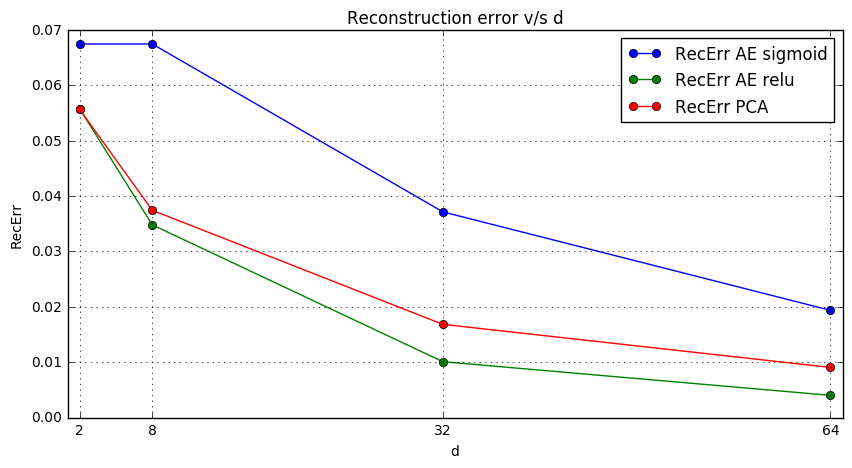

In [14]:
data_dict = {'RecErr AE sigmoid': rec_err_ae_sigmoid, 'RecErr AE relu':rec_err_ae_relu, 'RecErr PCA':rec_err_pca}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='RecErr', title='Reconstruction error v/s d')

#### Desempeño en clasificación

In [18]:
ca_pca = []

print('PCA + d=2')
acc = knn_classification_accuracy(pca_train_red[0], y_train, pca_test_red[0], y_test, verbose=0); ca_pca.append(acc)
print('Classification Accuracy: {0} \n'.format(acc))

print('PCA + d=8')
acc = knn_classification_accuracy(pca_train_red[1], y_train, pca_test_red[1], y_test, verbose=0); ca_pca.append(acc)
print('Classification Accuracy: {0} \n'.format(acc))

print('PCA + d=32')
acc = knn_classification_accuracy(pca_train_red[2], y_train, pca_test_red[2], y_test, verbose=0); ca_pca.append(acc)
print('Classification Accuracy: {0} \n'.format(acc))

print('PCA + d=64')
acc = knn_classification_accuracy(pca_train_red[3], y_train, pca_test_red[3], y_test, verbose=0); ca_pca.append(acc)
print('Classification Accuracy: {0}'.format(acc))

PCA + d=2
Classification Accuracy: 0.2554 

PCA + d=8
Classification Accuracy: 0.8749 

PCA + d=32
Classification Accuracy: 0.9656 

PCA + d=64
Classification Accuracy: 0.9633


En cuanto a resultados de clasificación, se nota que `PCA` logra el mejor resultado (para todos los valores de `d`). Sin embargo los resultados son muy similares a los del AE entranado con `relu`.

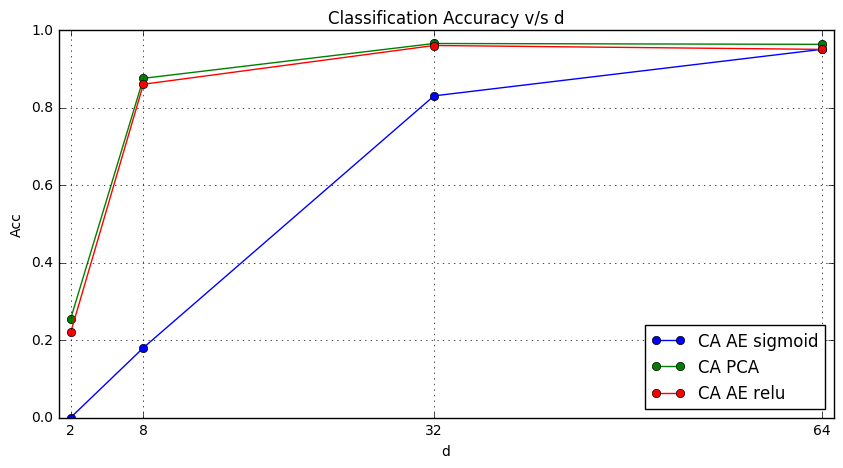

In [16]:
data_dict = {'CA AE sigmoid': ca_ae_sigmoid, 'CA AE relu':ca_ae_relu, 'CA PCA':ca_pca}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='Acc', title='Classification Accuracy v/s d', loc=4)

#### Desempeño en agrupamiento

In [19]:
acc_pca = []

print('PCA + d=2')
acc = clustering_scores(pca_train_red[0], y_train, verbose=0); acc_pca.append(acc)
print('Clustering ACC: {0} \n'.format(acc))

print('PCA + d=8')
acc = clustering_scores(pca_train_red[1], y_train, verbose=0); acc_pca.append(acc)
print('Clustering ACC: {0} \n'.format(acc))

print('PCA + d=32')
acc = clustering_scores(pca_train_red[2], y_train, verbose=0); acc_pca.append(acc)
print('Clustering ACC: {0} \n'.format(acc))

print('PCA + d=64')
acc = clustering_scores(pca_train_red[3], y_train, verbose=0); acc_pca.append(acc)
print('Clustering ACC: {0}'.format(acc))

PCA + d=2
Clustering ACC: 0.4089830508474576 

PCA + d=8
Clustering ACC: 0.5899322033898305 

PCA + d=32
Clustering ACC: 0.589406779661017 

PCA + d=64
Clustering ACC: 0.5903898305084746


En cuanto a capacidad de clusterización, nuevamente PCA muestra estabilidad y un desempeño. 

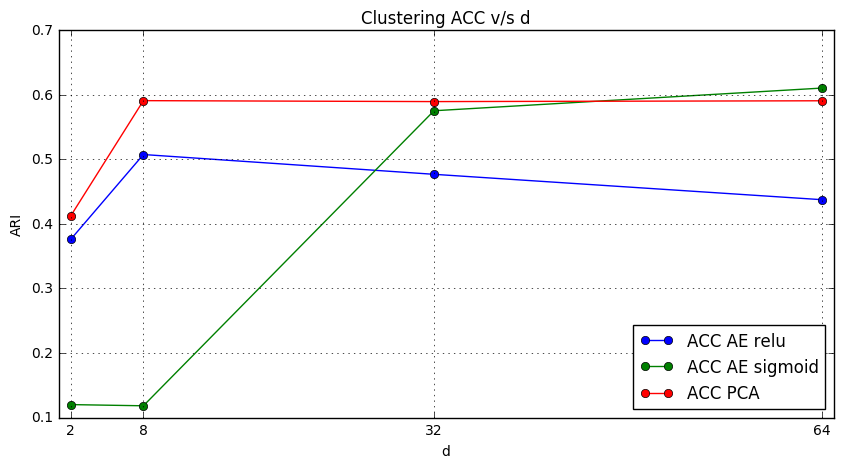

In [19]:
data_dict = {'ACC AE sigmoid': acc_ae_sigmoid, 'ACC AE relu':acc_ae_relu, 'ACC PCA':acc_pca}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='ARI', title='Clustering ACC v/s d', loc=4)

#### Visualización de la reconstrucción

Se muestra a continuación los resultados gráficos de las reconstrucciones generadas por las tres técnicas anteriores, para `d=8` y `d=64`. Como se puede apreciar en `d=64`, PCA no tan bien las imágenes comparado a como lo hacen los AEs. Sin embargo, como se notó anteriormente, pese a que la capacidad de reconstrucción no sea tan buena, la representación de baja dimensionalidad obtenida mejora el proceso de clasificación, que es lo realmente importante en este problema.

In [20]:
def visualize_reconstruction_pca(X_test, pca_test_rec):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(X_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(pca_test_rec[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

PCA + d=8


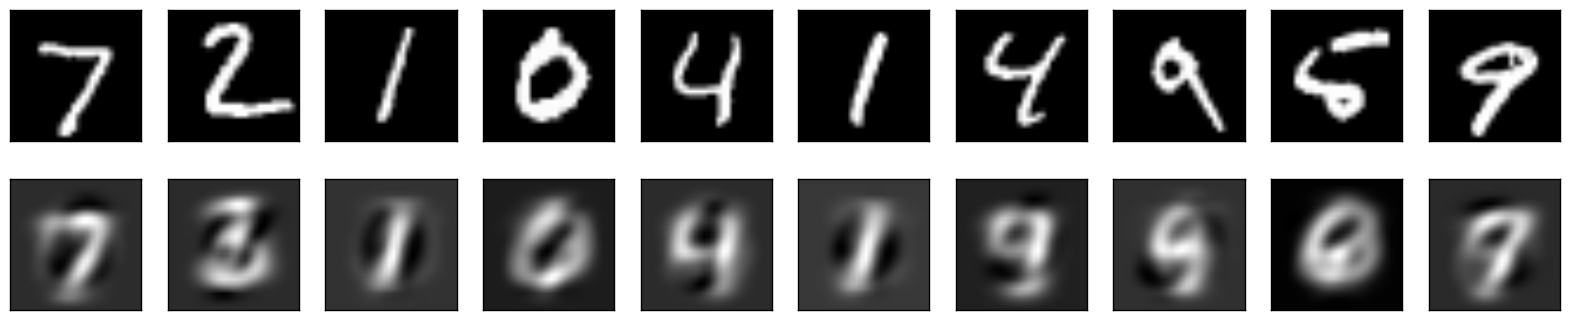

AE (sigmoid encoder) + d=8


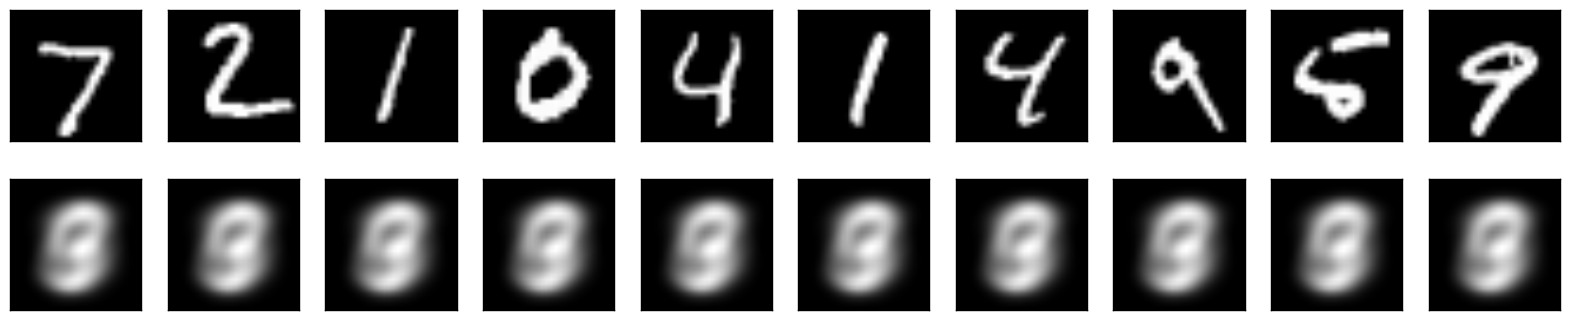

AE (relu encoder) + d=8


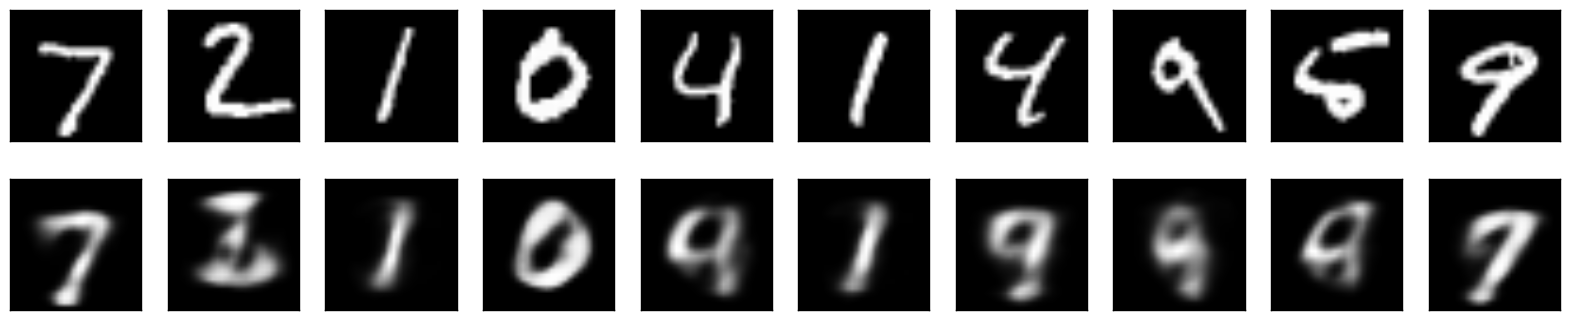

In [143]:
print('PCA + d=8')
visualize_reconstruction_pca(X_test, pca_test_rec[1])
print('AE (sigmoid encoder) + d=8')
visualize_reconstruction(X_test, ae_8d_sigmoid)
print('AE (relu encoder) + d=8')
visualize_reconstruction(X_test, ae_8d_relu)

PCA + d=64


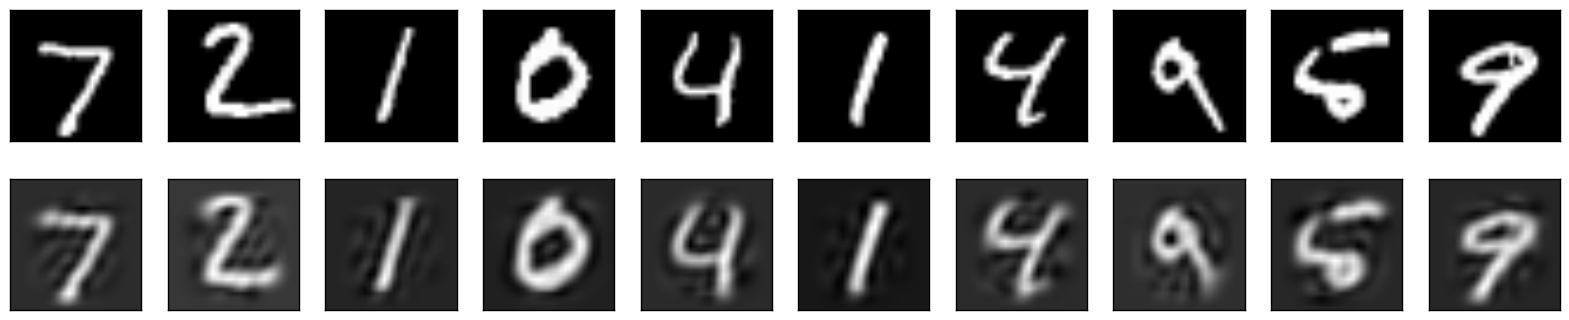

AE (sigmoid encoder) + d=64


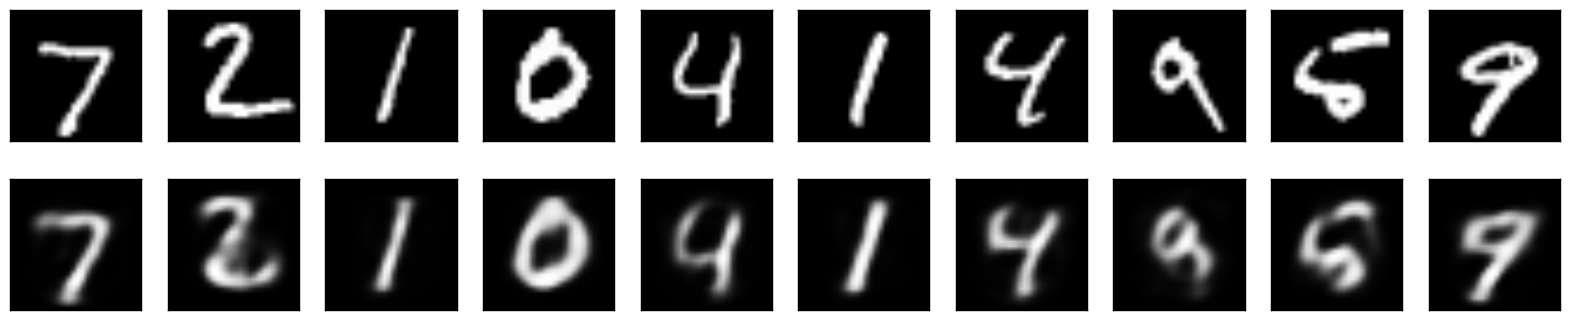

AE (relu encoder) + d=64


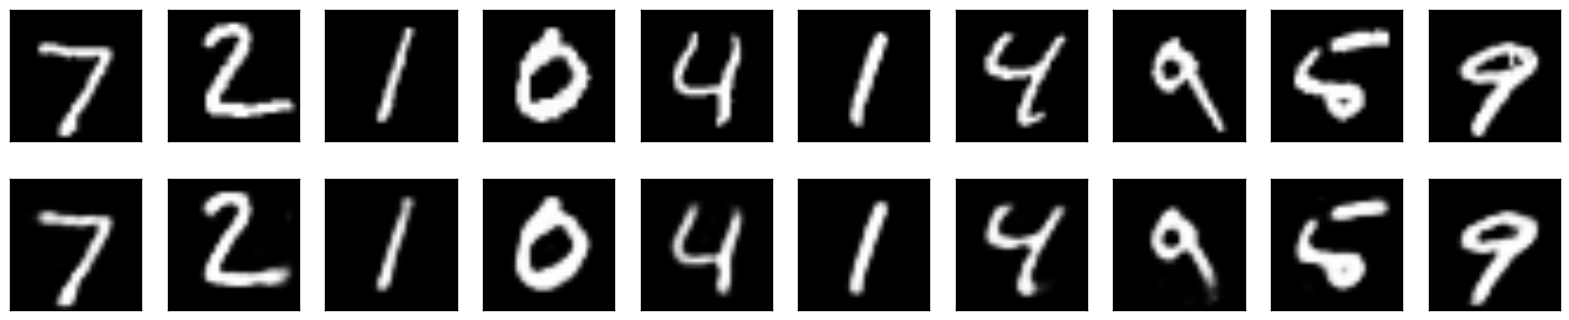

In [144]:
print('PCA + d=64')
visualize_reconstruction_pca(X_test, pca_test_rec[3])
print('AE (sigmoid encoder) + d=64')
visualize_reconstruction(X_test, ae_64d_sigmoid)
print('AE (relu encoder) + d=64')
visualize_reconstruction(X_test, ae_64d_relu)

<div id='1.1f'/>
### Parte (f)

In [21]:
def train_bernoulli_rbm(X_train, d=2):
    model = BernoulliRBM(n_components=d, batch_size=25, learning_rate=0.05, verbose=0, n_iter=50)
    model.fit(X_train)
    fileo = open('rbm_{0}d.pickle'.format(d),'wb')
    pickle.dump(model,fileo)
    fileo.close()
    return model

In [22]:
# ADVERTENCIA: la ejecucion de esta celda toma un tiempo considerable
rbm_2d = train_bernoulli_rbm(X_train, d=2)
rbm_8d = train_bernoulli_rbm(X_train, d=8)
rbm_32d = train_bernoulli_rbm(X_train, d=32)
rbm_64d = train_bernoulli_rbm(X_train, d=64)
rbm_list = [rbm_2d, rbm_8d, rbm_32d, rbm_64d]

**Nota:** Dado que la implementación de `scikit-learn` no provee un método del tipo `.inverse_transform()`, no existe una manera directa de calcular la reconstrucción que genera la RBM. Por lo mismo se han omitido los errores de reconstrucción en esta sección.

#### Desempeño en clasificación

In [48]:
ca_rbm = []
for i in range(4):
    X_train_red = rbm_list[i].transform(X_train)
    X_test_red = rbm_list[i].transform(X_test)
    ca_rbm.append( knn_classification_accuracy(X_train_red, y_train, X_test_red , y_test, verbose=0) )

Se comparan a continuación los resultados obtenidos con RBMs, contra todas las otras técnicas utilizadas anteriormente. Se verifica que la capacidad de clasificación no supera la de AE+`relu` y PCA. 

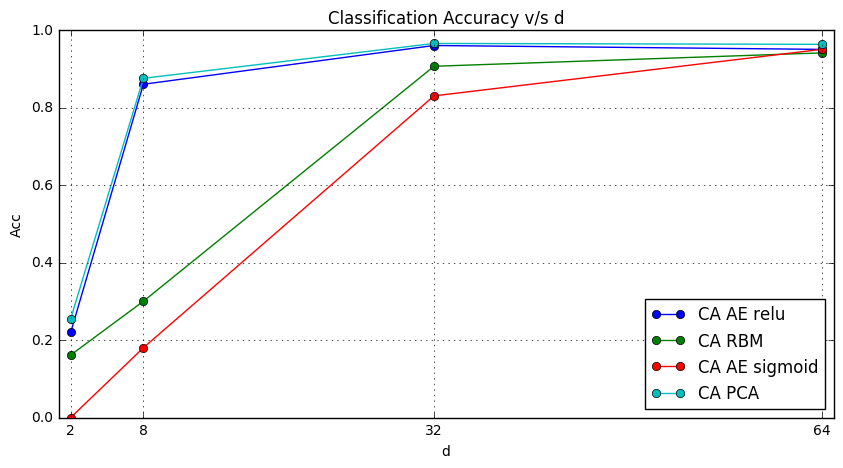

In [49]:
data_dict = {'CA AE sigmoid': ca_ae_sigmoid, 'CA AE relu':ca_ae_relu, 'CA PCA':ca_pca, 'CA RBM':ca_rbm}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='Acc', title='Classification Accuracy v/s d', loc=4)

#### Desempeño en agrupamiento

In [50]:
acc_rbm = []
for i in range(4):
    X_train_red = rbm_list[i].transform(X_train)
    acc_rbm.append( clustering_scores(X_train_red, y_train, verbose=0) )

Sin embargo la representación aprendida con RBM logra el mejor desempeño en la tarea de clusterizar los datos, para valores de `d` mayores a $32$. 

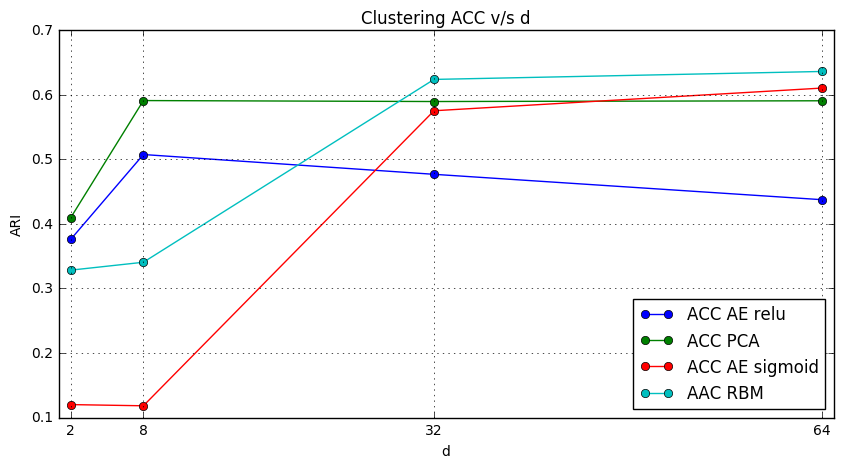

In [51]:
data_dict = {'ACC AE sigmoid': acc_ae_sigmoid, 'ACC AE relu':acc_ae_relu, 'ACC PCA':acc_pca, 'AAC RBM':acc_rbm}
show_results(data_dict, [2,8,32,64], xlabel='d', ylabel='ARI', title='Clustering ACC v/s d', loc=4)

<div id='1.1g'/>
### Parte (g)

La siguiente función permite entrenar de forma genérica un deep AE (dAE), con nivel de profundidad y activación configuradas según los parámetros.

In [45]:
def train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 2], activation='relu'):
    layers_list = []
    layers_list.append( Input(shape=(784,)) )
    # encoding model
    for size in layer_sizes:
        layers_list.append( Dense(size, activation=activation)(layers_list[-1]) )
    encoded = layers_list[-1]
    # decoding model
    for size in layer_sizes[-2::-1]:
        layers_list.append( Dense(size, activation=activation)(layers_list[-1]) )
    layers_list.append( Dense(784, activation='sigmoid')(layers_list[-1]) )
    # encoder and autoencoder model
    encoder = Model(input=layers_list[0], output=encoded)
    autoencoder = Model(input=layers_list[0], output=layers_list[-1])
    # training step
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(X_train, X_train, nb_epoch=50, batch_size=25, shuffle=True, validation_data=(X_val, X_val))
    # saving results
    encoder.save('enc_{0}L_{1}d.h5'.format(len(layer_sizes), layer_sizes[-1]))
    autoencoder.save('ae_{0}L_{1}d.h5'.format(len(layer_sizes), layer_sizes[-1]))
    return autoencoder

#### `Layer size: 2`

In [ ]:
### ADVERTENCIA: La ejecucion de esta celda toma una cantidad considerable de tiempo
ae_2L_2d = train_deep_ae(X_train, X_val, layer_sizes=[250, 2])
ae_2L_4d = train_deep_ae(X_train, X_val, layer_sizes=[250, 4])
ae_2L_8d = train_deep_ae(X_train, X_val, layer_sizes=[250, 8])
ae_2L_16d = train_deep_ae(X_train, X_val, layer_sizes=[250, 16])
ae_2L_32d = train_deep_ae(X_train, X_val, layer_sizes=[250, 32])

In [20]:
# Carga de modelos entrenados previamente
base_dir = 'results-part1/'
ae_2L_2d = load(base_dir+'ae_2L_2d'); enc_2L_2d = load(base_dir+'enc_2L_2d')
ae_2L_4d = load(base_dir+'ae_2L_4d'); enc_2L_4d = load(base_dir+'enc_2L_4d')
ae_2L_8d = load(base_dir+'ae_2L_8d'); enc_2L_8d = load(base_dir+'enc_2L_8d')
ae_2L_16d = load(base_dir+'ae_2L_16d'); enc_2L_16d = load(base_dir+'enc_2L_16d')
ae_2L_32d = load(base_dir+'ae_2L_32d'); enc_2L_32d = load(base_dir+'enc_2L_32d')

In [21]:
ae_2L = [ae_2L_2d, ae_2L_4d, ae_2L_8d, ae_2L_16d, ae_2L_32d]
enc_2L = [enc_2L_2d, enc_2L_4d, enc_2L_8d, enc_2L_16d, enc_2L_32d]
# computo de error de reconstruccion, precision de clasificacion, y precision de agrupamiento
rec_err_dae_2L = []; ca_dae_2L = []; acc_dae_2L = []
for i in range(5): 
    err = rec_err(X_test, ae_2L[i].predict(X_test)); rec_err_dae_2L.append(err)
    X_train_red = enc_2L[i].predict(X_train)
    X_test_red = enc_2L[i].predict(X_test)
    ca_dae_2L.append( knn_classification_accuracy(X_train_red, y_train, X_test_red , y_test, verbose=0) )
    acc_dae_2L.append( clustering_scores(X_train_red, y_train, verbose=0) )

#### `Layer size: 3`

In [ ]:
### ADVERTENCIA: La ejecucion de esta celda toma una cantidad considerable de tiempo
ae_3L_2d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 2])
ae_3L_4d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 4])
ae_3L_8d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 8])
ae_3L_16d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 16])
ae_3L_32d = train_deep_ae(X_train, X_val, layer_sizes=[500, 250, 32])

In [22]:
# Carga de modelos entrenados previamente
ae_3L_2d = load(base_dir+'ae_3L_2d'); enc_3L_2d = load(base_dir+'enc_3L_2d')
ae_3L_4d = load(base_dir+'ae_3L_4d'); enc_3L_4d = load(base_dir+'enc_3L_4d')
ae_3L_8d = load(base_dir+'ae_3L_8d'); enc_3L_8d = load(base_dir+'enc_3L_8d')
ae_3L_16d = load(base_dir+'ae_3L_16d'); enc_3L_16d = load(base_dir+'enc_3L_16d')
ae_3L_32d = load(base_dir+'ae_3L_32d'); enc_3L_32d = load(base_dir+'enc_3L_32d')

In [23]:
ae_3L = [ae_3L_2d, ae_3L_4d, ae_3L_8d, ae_3L_16d, ae_3L_32d]
enc_3L = [enc_3L_2d, enc_3L_4d, enc_3L_8d, enc_3L_16d, enc_3L_32d]
# computo de error de reconstruccion, precision de clasificacion, y precision de agrupamiento
rec_err_dae_3L = []; ca_dae_3L = []; acc_dae_3L = []
for i in range(5): 
    err = rec_err(X_test, ae_3L[i].predict(X_test)); rec_err_dae_3L.append(err)
    X_train_red = enc_3L[i].predict(X_train)
    X_test_red = enc_3L[i].predict(X_test)
    ca_dae_3L.append( knn_classification_accuracy(X_train_red, y_train, X_test_red , y_test, verbose=0) )
    acc_dae_3L.append( clustering_scores(X_train_red, y_train, verbose=0) )

#### `Layer size: 4`

In [ ]:
### ADVERTENCIA: La ejecucion de esta celda toma una cantidad considerable de tiempo
ae_4L_2d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 2])
ae_4L_4d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 4])
ae_4L_8d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 8])
ae_4L_16d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 16])
ae_4L_32d = train_deep_ae(X_train, X_val, layer_sizes=[1000, 500, 250, 32])

In [24]:
# Carga de modelos entrenados previamente
ae_4L_2d = load(base_dir+'ae_4L_2d'); enc_4L_2d = load(base_dir+'enc_4L_2d')
ae_4L_4d = load(base_dir+'ae_4L_4d'); enc_4L_4d = load(base_dir+'enc_4L_4d')
ae_4L_8d = load(base_dir+'ae_4L_8d'); enc_4L_8d = load(base_dir+'enc_4L_8d')
ae_4L_16d = load(base_dir+'ae_4L_16d'); enc_4L_16d = load(base_dir+'enc_4L_16d')
ae_4L_32d = load(base_dir+'ae_4L_32d'); enc_4L_32d = load(base_dir+'enc_4L_32d')

In [25]:
ae_4L = [ae_4L_2d, ae_4L_4d, ae_4L_8d, ae_4L_16d, ae_4L_32d]
enc_4L = [enc_4L_2d, enc_4L_4d, enc_4L_8d, enc_4L_16d, enc_4L_32d]
# computo de error de reconstruccion, precision de clasificacion, y precision de agrupamiento
rec_err_dae_4L = []; ca_dae_4L = []; acc_dae_4L = []
for i in range(5): 
    err = rec_err(X_test, ae_4L[i].predict(X_test)); rec_err_dae_4L.append(err)
    X_train_red = enc_4L[i].predict(X_train)
    X_test_red = enc_4L[i].predict(X_test)
    ca_dae_4L.append( knn_classification_accuracy(X_train_red, y_train, X_test_red , y_test, verbose=0) )
    acc_dae_4L.append( clustering_scores(X_train_red, y_train, verbose=0) )

#### Sumario de resultados

En cuanto a capacidad de reconstrucción, no se ve una diferencia signficativa al aumentar el nivel de profundidad de los AE. Para `d=32` todos producen en error similar. Se concluye que para estos propósitos no es necesaria una arquitectura muy profunda.

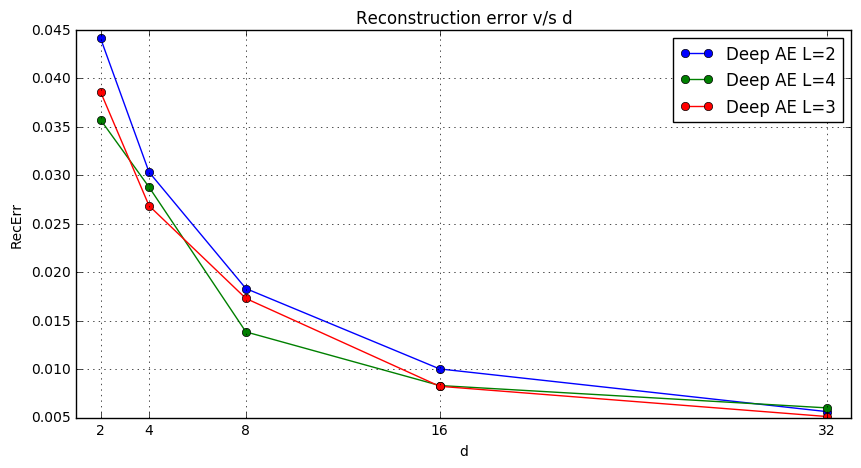

In [26]:
data_dict = {'Deep AE L=2': rec_err_dae_2L, 'Deep AE L=3': rec_err_dae_3L, 'Deep AE L=4': rec_err_dae_4L}
show_results(data_dict, [2,4,8,16,32], xlabel='d', ylabel='RecErr', title='Reconstruction error v/s d')

En cuanto a capacidad de clasificación, ahora sí se notan diferencias para la arquitectura con `L=2`, la cual para valores bajos de `d` obtienen un `accuracy` muy bajo. Por otro lado las arquitectura con `L=3` y `L=4` poseen resultados similares.

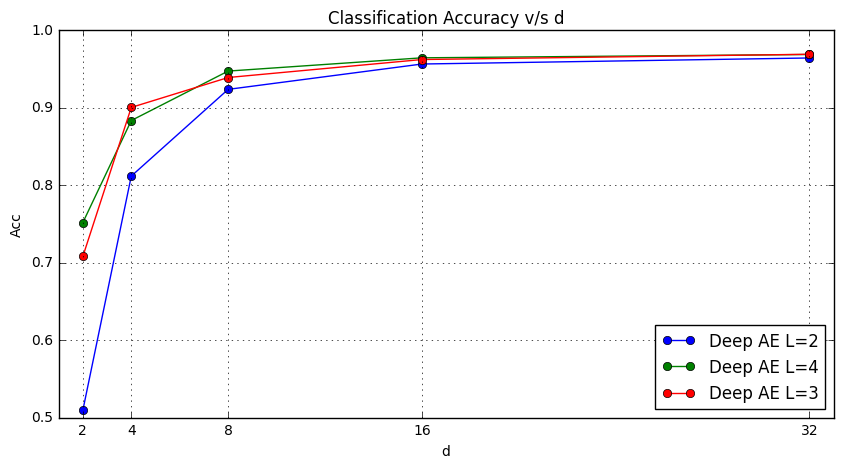

In [27]:
data_dict = {'Deep AE L=2': ca_dae_2L, 'Deep AE L=3': ca_dae_3L, 'Deep AE L=4': ca_dae_4L}
show_results(data_dict, [2,4,8,16,32], xlabel='d', ylabel='Acc', title='Classification Accuracy v/s d', loc=4)

En cuanto a capacidad de clusterización los resultados son bastante variables. Las arquitectura de `L=3` y `L=4` poseen un comportamiento similar, dando mejores resultados la arquitectura más profunda.

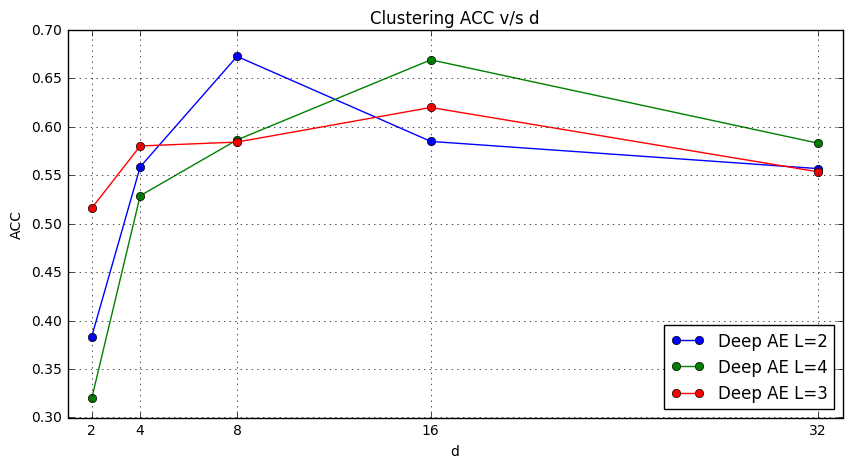

In [28]:
data_dict = {'Deep AE L=2': acc_dae_2L, 'Deep AE L=3': acc_dae_3L, 'Deep AE L=4': acc_dae_4L}
show_results(data_dict, [2,4,8,16,32], xlabel='d', ylabel='ACC', title='Clustering ACC v/s d', loc=4)

<div id='1.1h'/>
### Parte (h)

In [47]:
nplot=1000

def show_representation(encoded_train, nplot=nplot, title=None):
    model = TSNE(n_components=2, random_state=0)
    encoded_train = model.fit_transform(encoded_train)
    y_train_ = np.argmax(y_train, axis=1)
    colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
    markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}
    plt.figure(figsize=(5, 5))
    for idx in range(0,nplot):
        label = y_train_[idx]
        line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
        color=colors[label], marker=markers[label], markersize=4)
    if title is not None: plt.title(title)
    plt.show()

Se muestran a continuación las representaciones aprendidas por los deep AE anteriores (con `d=2`) y también para PCA.

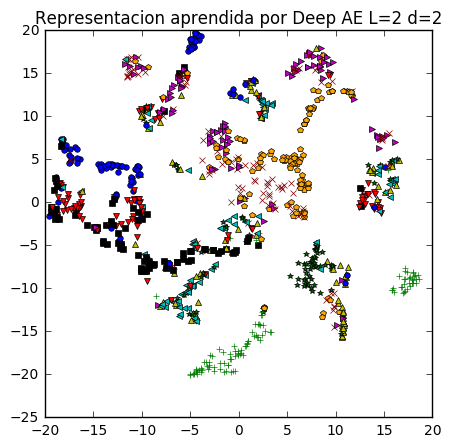

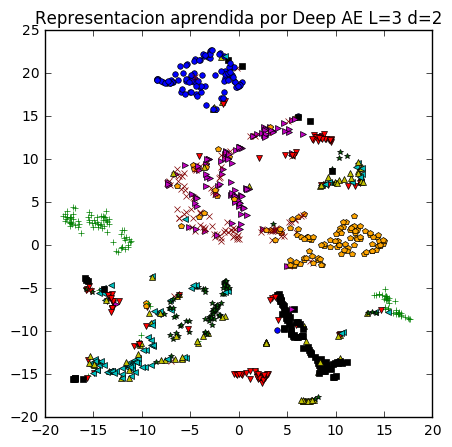

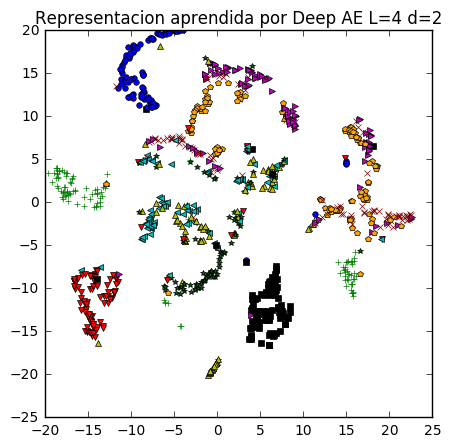

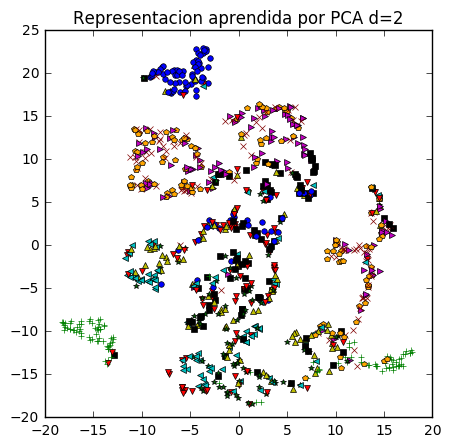

In [55]:
show_representation(enc_2L_2d.predict(X_train[:nplot]), title='Representacion aprendida por Deep AE L=2 d=2')
show_representation(enc_3L_2d.predict(X_train[:nplot]), title='Representacion aprendida por Deep AE L=3 d=2')
show_representation(enc_4L_2d.predict(X_train[:nplot]), title='Representacion aprendida por Deep AE L=4 d=2')
show_representation(pca_train_red[0][:nplot], title='Representacion aprendida por PCA d=2')

Los gráficos anteriores muestran como a medida que el nivel de profundidad de los AE aumenta, más se clusterizan las representaciones de cada número, haciendo por tanto más fácil la tarea de clasificación. La representación obtenida en PCA es más dispersa, y comparable a la obtenida con arquitecturas poco profundas de AE.

<div id='1.1i'/>
### Parte (i)

La función que se provee a continuación, muestra todo los pesos desde la capa de entrada hacia una de las neuronas de la capa oculta (tal neurona se controla con el parámetro `n`).

In [76]:
"""
ae -> Modelo de autoencoder
n -> indice de neurona de la capa oculta para la cual se muestran los pesos
"""
def visualize_weigths(ae, n=0):
    plt.figure(figsize=(10,5))
    plt.plot(range(1,785), ae.get_weights()[0][:,n])
    plt.xlabel('Input connection')
    plt.ylabel('weight value')
    plt.show()

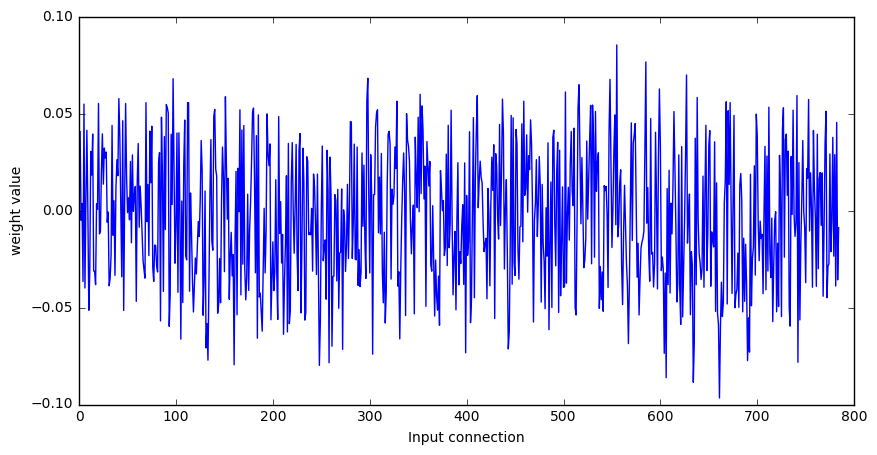

In [79]:
visualize_weigths(ae_4L_32d, n=800)

<div id='den'/>
## 1.2 - Denoising

<div id='1.2a'/>
### Parte (a)

In [41]:
def bernoulli_noise(X_train, X_val, noise_level=0.1):
    noise_mask = np.random.binomial(n=1, p=noise_level, size=X_train.shape)
    X_train_noisy = X_train*noise_mask
    noise_mask = np.random.binomial(n=1, p=noise_level, size=X_val.shape)
    X_val_noisy = X_val*noise_mask
    return X_train_noisy, X_val_noisy

In [43]:
X_train_noisy1, X_val_noisy1 = bernoulli_noise(X_train, X_val)

<div id='1.2b'/>
### Parte (b)

In [137]:
def train_dae(X_train, X_val, noise_type, noise_level=0, devst=0., hidden_size=32):
    if noise_type=='bernoulli': X_train_noisy, X_val_noisy = bernoulli_noise(X_train, X_val, noise_level=noise_level)
    elif noise_type=='gaussian': X_train_noisy, X_val_noisy = gaussian_noise(X_train, X_val, devst=devst)
    input_img = Input(shape=(784,))
    encoded = Dense(hidden_size, activation='relu')(input_img)
    decoded = Dense(784, activation='sigmoid')(encoded)
    # building encoder, decoder and autoencoder
    autoencoder = Model(input=input_img, output=decoded)
    encoder = Model(input=input_img, output=encoded)
    encoded_input = Input(shape=(hidden_size,))
    decoder_layer = autoencoder.layers[-1]
    decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))
    autoencoder.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy')
    autoencoder.fit(X_train_noisy, X_train, nb_epoch=50, batch_size=25, shuffle=True, 
                    validation_data=(X_val_noisy, X_val), verbose=0)
    return encoder, autoencoder

A continuación se proceden a entrenar cinco *denoising autoencoder* para valores de `noise_level` $\in [0.1, 0.2, 0.3, 0.4, 0.5]$.

In [50]:
dae_ber_list = []; denc_ber_list = []
for noise in [0.1, 0.2, 0.3, 0.4, 0.5]:
    enc, ae  = train_dae(X_train, X_val, noise_type='bernoulli', noise_level=noise)
    denc_ber_list.append(enc)
    dae_ber_list.append(ae)

Reconstruccion de Denoising Autoencoder (Bernoulli noise) con noise_level=0.1


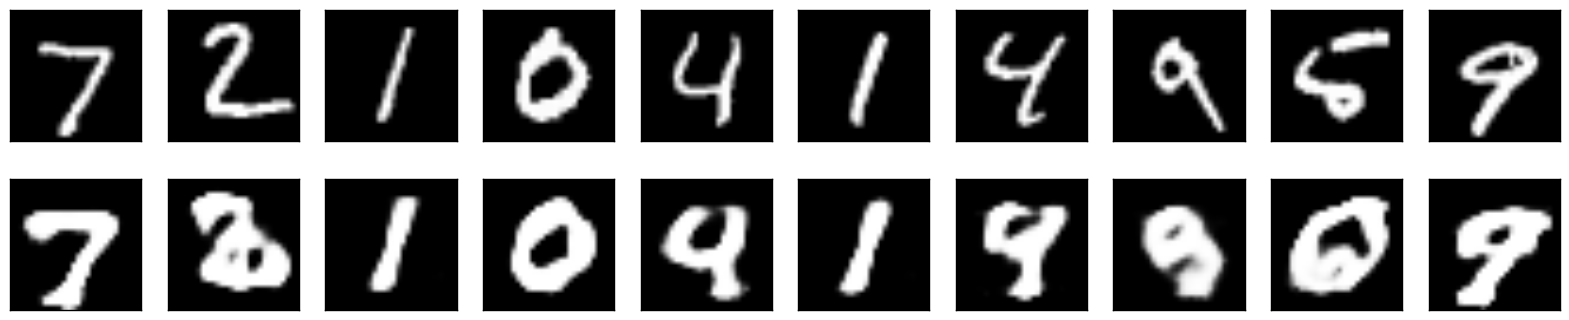

Reconstruccion de Denoising Autoencoder (Bernoulli noise) con noise_level=0.2


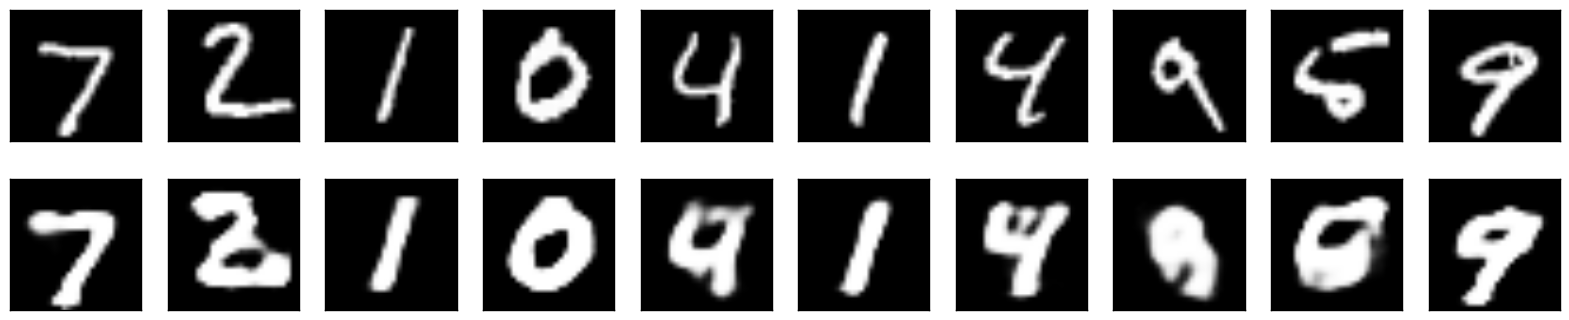

Reconstruccion de Denoising Autoencoder (Bernoulli noise) con noise_level=0.3


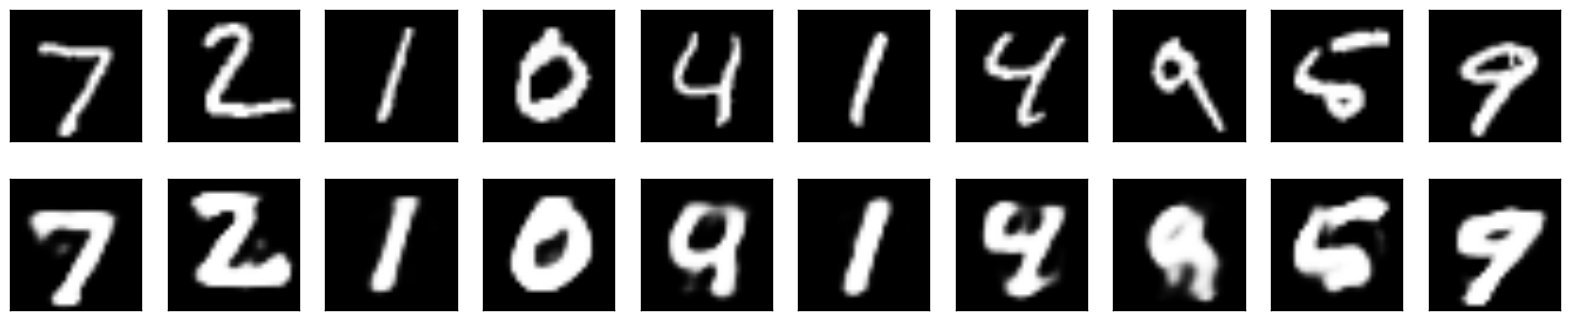

Reconstruccion de Denoising Autoencoder (Bernoulli noise) con noise_level=0.4


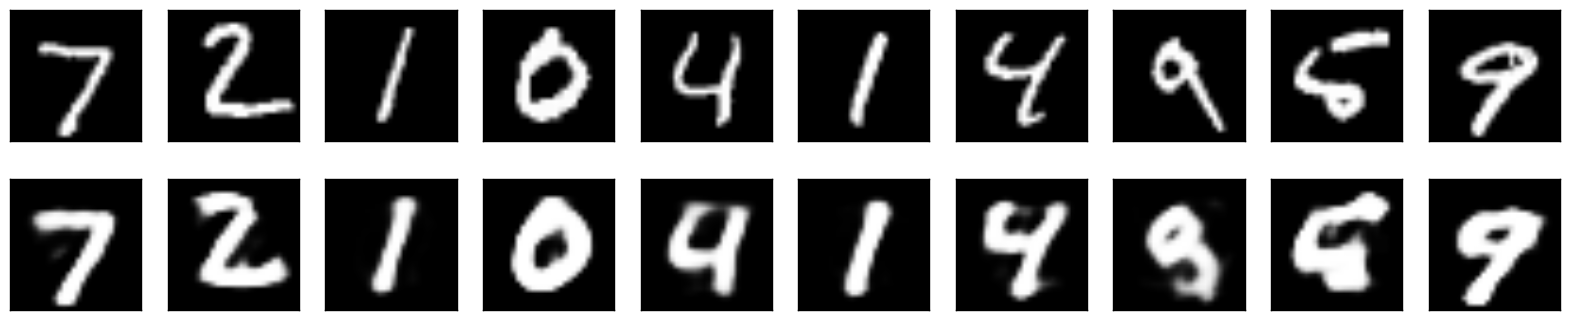

Reconstruccion de Denoising Autoencoder (Bernoulli noise) con noise_level=0.5


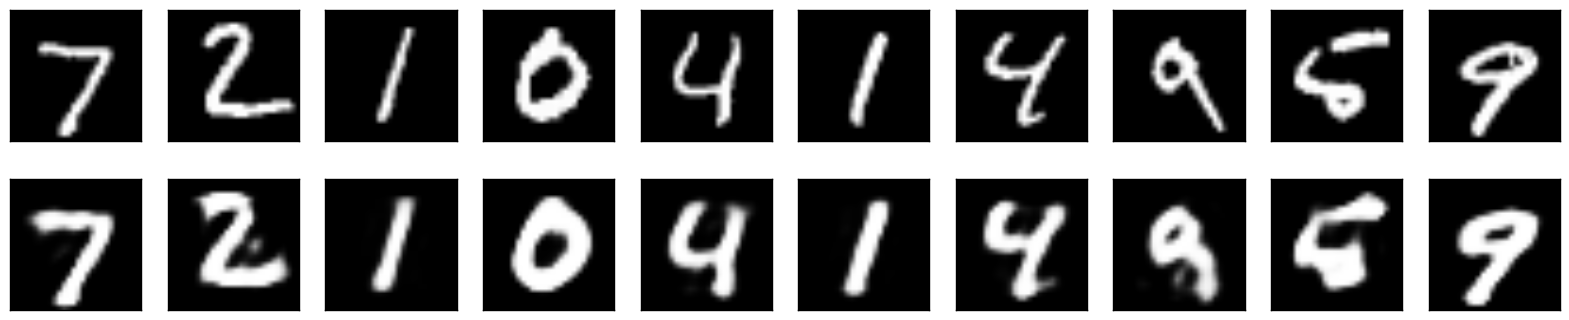

In [63]:
for i,noise in enumerate([0.1, 0.2, 0.3, 0.4, 0.5]):
    print('Reconstruccion de Denoising Autoencoder (Bernoulli noise) con noise_level={0}'.format(noise))
    visualize_reconstruction(X_test, dae_ber_list[i])

A primera vista, las mejores reconstrucciones se alcanzan con valores de `noise_level` altos. Las primera imágenes reconstruidas presentan varios problemas para algunos ejemplos, mientras que cuando `noise_level=0.5` los resultados son más parecidos. Otro aspecto a notar, es el *suavizamiento* de las imágenes reconstruidas.

In [69]:
rec_err_dae_ber = []
for dae in dae_ber_list:
    rec_err_dae_ber.append( rec_err(X_test, dae.predict(X_test)) )

El gráfico de error de reconstrucción siguiente, corrobora el resultado visual obtenido anteriormente, i.e, mientras mayor es el `noise_level` de la distribución de ruido bernoulli, mejor es la capacidad de reconstruccción.

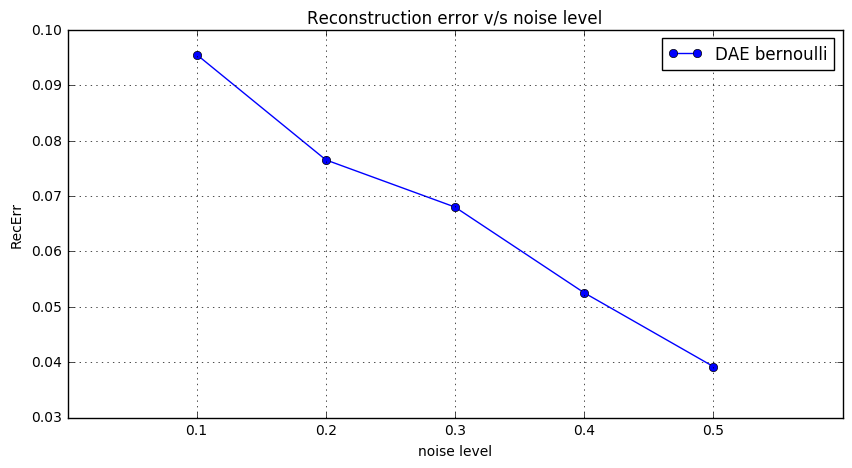

In [72]:
data_dict = {'DAE bernoulli': rec_err_dae_ber}
show_results(data_dict, [0.1,0.2,0.3,0.4,0.5], xlabel='noise level', ylabel='RecErr', title='Reconstruction error v/s noise level')

<div id='1.2c'/>
### Parte (c)

In [51]:
def gaussian_noise(X_train, X_val, devst=0.5):
    noise_mask = devst*np.random.standard_normal(size=X_train.shape)
    X_train_noisy = X_train + noise_mask
    noise_mask = devst*np.random.standard_normal(size=X_val.shape)
    X_val_noisy = X_val + noise_mask
    noise_mask = devst*np.random.standard_normal(size=X_test.shape)
    X_test_noisy = X_test + noise_mask
    return X_train_noisy, X_val_noisy

In [52]:
X_train_noisy2, X_val_noisy2 = gaussian_noise(X_train, X_val)

<div id='1.2d'/>
### Parte (d)

A continuación se proceden a entrenar cinco *denoising autoencoder* (con ruido gaussiano) para valores de `devst` $\in [0.1, 0.25, 0.5, 0.75, 0.9]$.

In [53]:
dae_gauss_list = []; denc_gauss_list = []
for devst in [0.1, 0.25, 0.5, 0.75, 0.9]:
    enc, ae  = train_dae(X_train, X_val, noise_type='gaussian', devst=st=st=st=devst)
    denc_gauss_list.append(enc)
    dae_gauss_list.append(ae)

Reconstruccion de Denoising Autoencoder (Gaussian noise) con devst=0.1


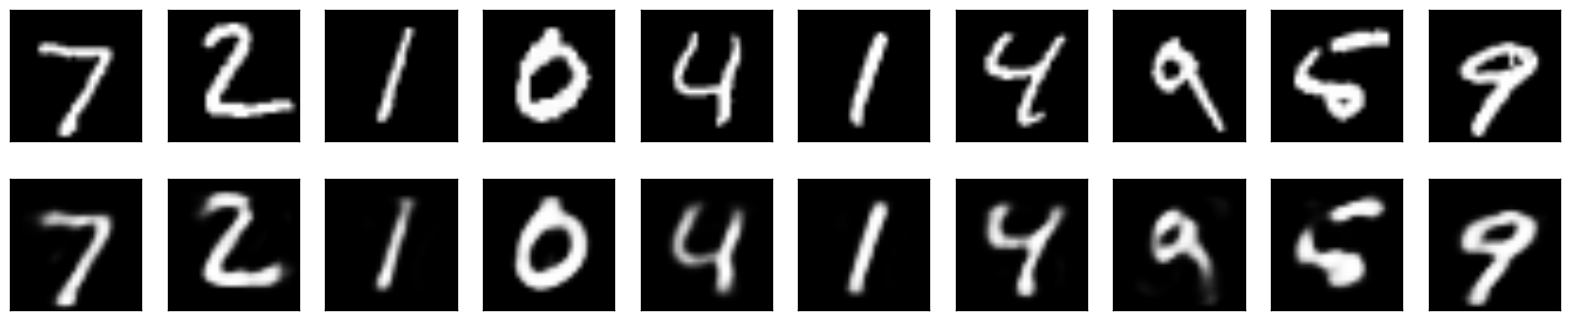

Reconstruccion de Denoising Autoencoder (Gaussian noise) con devst=0.25


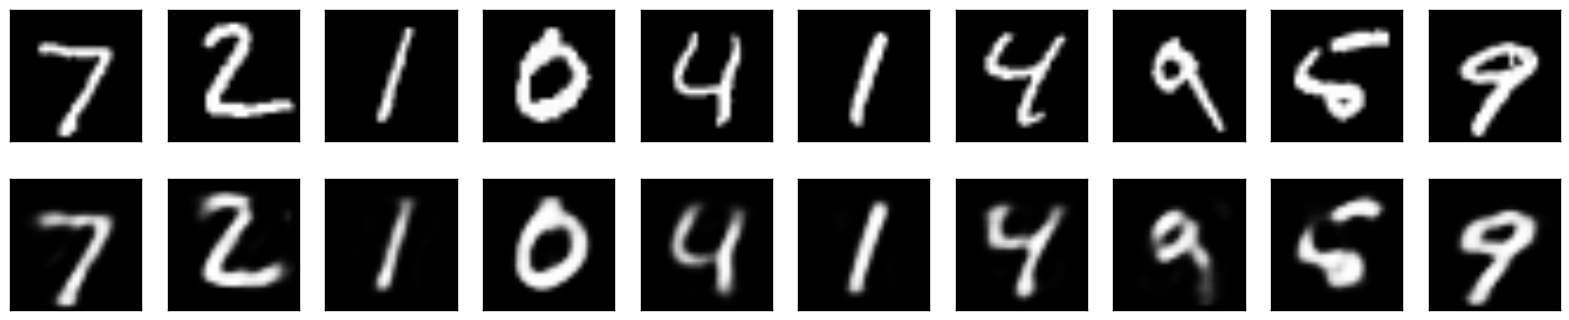

Reconstruccion de Denoising Autoencoder (Gaussian noise) con devst=0.5


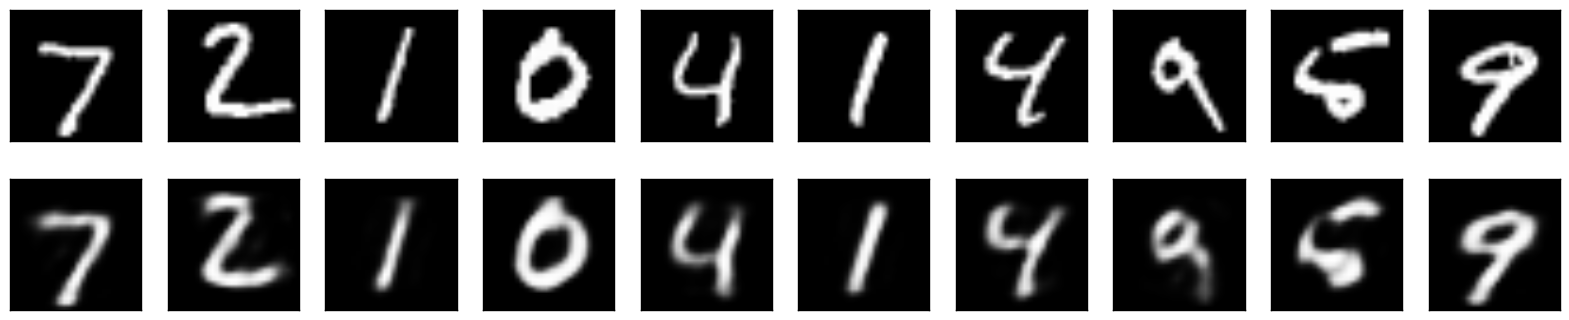

Reconstruccion de Denoising Autoencoder (Gaussian noise) con devst=0.75


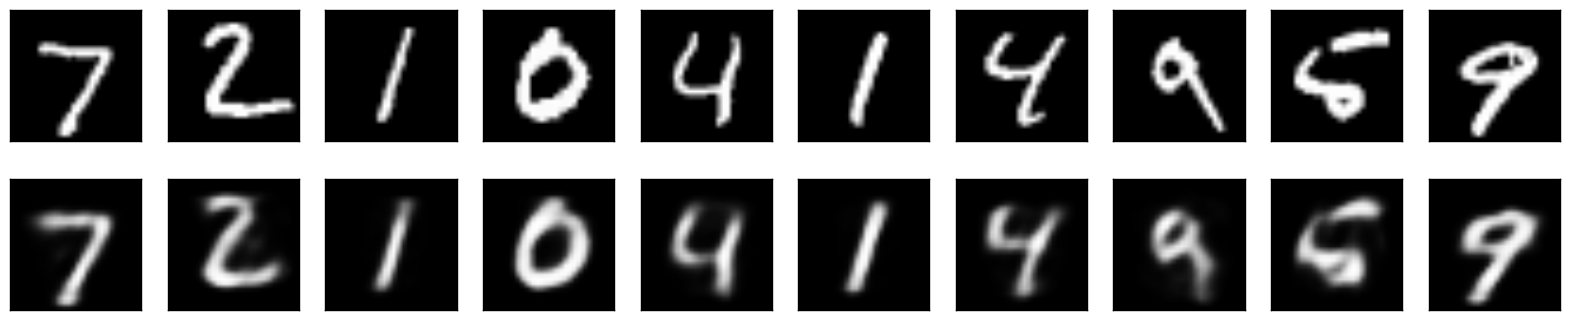

Reconstruccion de Denoising Autoencoder (Gaussian noise) con devst=0.9


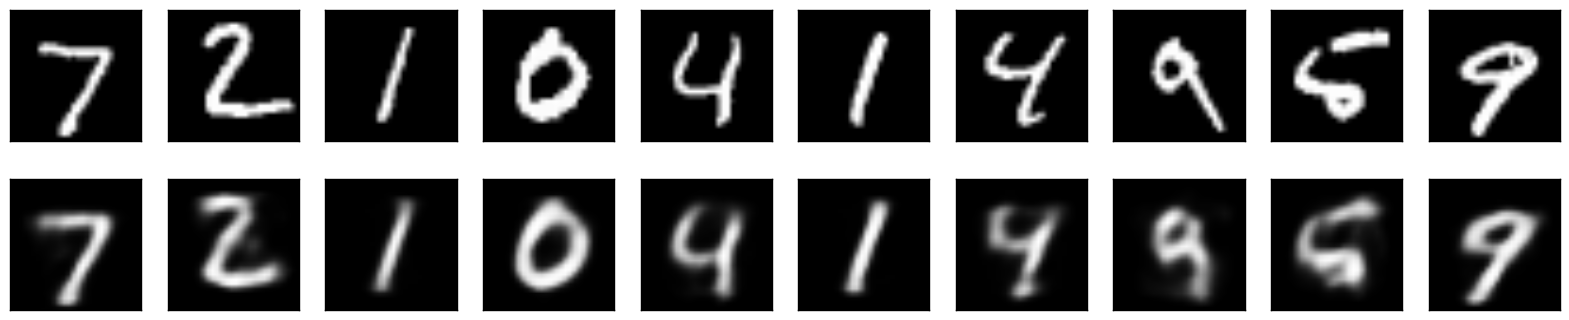

In [61]:
for i,devst in enumerate([0.1, 0.25, 0.5, 0.75, 0.9]):
    print('Reconstruccion de Denoising Autoencoder (Gaussian noise) con devst={0}'.format(devst))
    visualize_reconstruction(X_test, dae_gauss_list[i])

A primera vista, las mejores reconstrucciones se alcanzan cuando `devst` es más bajo, notandose reconstrucciones *ruidosas* para `devst=0.9`.

In [66]:
rec_err_dae_gauss = []
for dae in dae_gauss_list:
    rec_err_dae_gauss.append( rec_err(X_test, dae.predict(X_test)) )

El gráfico de error de reconstrucción siguiente, corrobora el resultado visual obtenido anteriormente, i.e, mientras mayor es el `devst` de la distribución de ruido gaussiana, peor es la capacidad de reconstruccción.

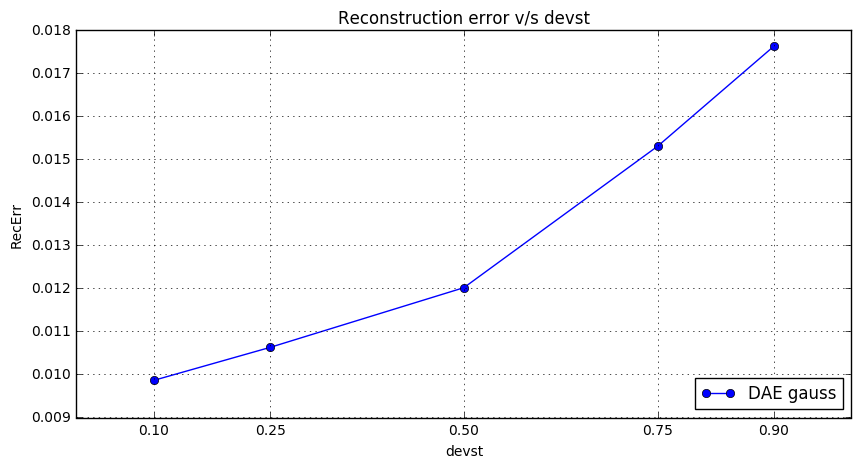

In [74]:
data_dict = {'DAE gauss': rec_err_dae_gauss}
show_results(data_dict, [0.1,0.25,0.5,0.75,0.9], xlabel='devst', ylabel='RecErr', 
             title='Reconstruction error v/s devst', loc=4)

<div id='1.2e'/>
### Parte (e)

In [135]:
"""
ae -> Modelo de autoencoder
dae -> Modelo del denoising autoencoder
n -> indice de neurona de la capa oculta para la cual se muestran los pesos
"""
def visualize_weigths2(ae, dae, n=0):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(range(1,785), ae.get_weights()[0][:,n])
    plt.title('Autoencoder')
    plt.xlabel('Input connection')
    plt.ylabel('weight value')
    plt.subplot(1,2,2)
    plt.plot(range(1,785), dae.get_weights()[0][:,n])
    plt.title('Denoising Autoencoder')
    plt.xlabel('Input connection')
    plt.ylabel('weight value')    
    plt.show()

def animate_weigths(n):
    visualize_weigths2(ae_32d_relu, dae_gauss_list[0], n=n)

La función que se provee, permite visualizar los pesos de las conexiones a cada una de las neuronas de la capa oculta (controlado por el índice de la neurona de la capa oculta `n` $\in [0,31]$).  


Para hacer la comparación justa, se utiliza un AE con `d=32` y activación `relu` en el encoder, contra un DAE con la misma configuración, y ruido gaussiano `devst=0.1` (el que obtuvo mejor desempeño anteriormente).

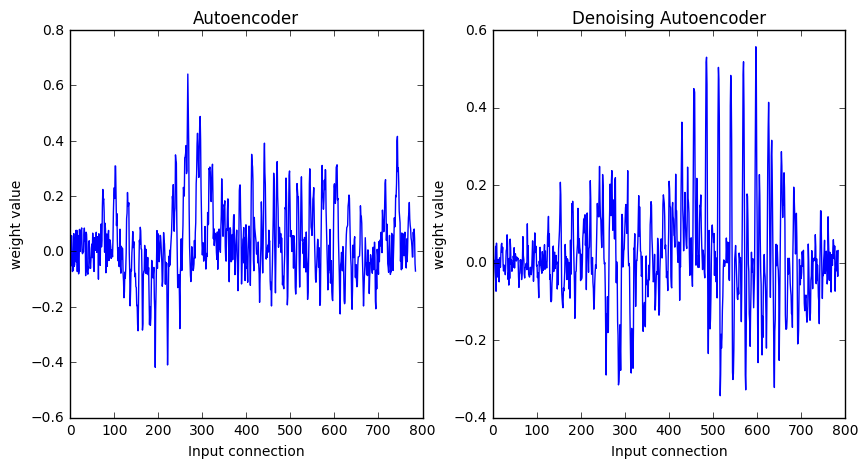

In [136]:
interact(animate_weigths, n=[0,31])

Como se aprecia, existen diferencias sustanciales en los patrones de pesos para cada neurona. Esto nos está indicando que en efecto, la representación que se obtiene al agregar ruido a la imágen de en entrada es distinta, a la cual obtiene el autoencoder clásico.

<div id='1.2f'/>
### Parte (f)

A primera impresión parece anti-intuitivo que el DAE, entrenado con datos corruptos, pudiese tener una mejor representación (en el sentido de la reconstrucción), que la que obtiene AE entrenado con los datos originales. Esto es, parece anti-intuitivo que el DAE, al aprender la transformación desde datos corruptos a los datos originales, obtenga en el proceso una representación (de menor dimensionalidad) mejor.


A continuación se compara los resultados de un AE de una sóla capa oculta, con $d=32$ y activación `relu` en el encoder, contra un DAE con la misma configuración, y `devst=0.1`. Las pruebas son ejecutadas en el conjunto de prueba.


Como puede verse, el DAE obtiene menor error de reconstrucción, lo cual indica que pese a que la hipótesis es anti-intuitiva, agregar ruido a la imagen de entrada puede ayudar a tener representaciones robustas de menor dimensionalidad.  Por otro lado, al aumentar `devst` (mayor a $0.1$) el error empieza a crecer, lo cual indica que el error que se introduce debe ser moderado.


In [146]:
dae_32d_relu = dae_gauss_list[0]
print('AE + d=32 + ReLU Encoder Activation')
print('Rec Err: {0} \n'.format(rec_err(X_test, ae_32d_relu.predict(X_test))))

print('DAE + d=32 + ReLU Encoder Activation + Gaussian noise (devst=0.1)')
print('Rec Err: {0}'.format(rec_err(X_test, dae_32d_relu.predict(X_test))))

AE + d=32 + ReLU Encoder Activation
Rec Err: 0.010080739593505859 

DAE + d=32 + ReLU Encoder Activation + Gaussian noise (devst=0.1)
Rec Err: 0.009863111114501954


<div id='pretr'/>
## 1.3 - Pre-entrenamiento

In [105]:
"""
Input:
> hist - history dict from model.fit() method
Output:
> plot of training and validation loss vs epochs
"""
def history_plot(hist_list, labels, n_epoch=20, title=None):
    fig = plt.figure(figsize=(16,8))
    ax = fig.gca()
    ax.set_xticks(np.linspace(1,n_epoch+1,20))
    #ax.set_yticks(np.linspace(0,1,10))
    plt.xlim(0,n_epoch+1)
    if title is not None: plt.title(title)
    for i,hist in enumerate(hist_list):
        plt.plot(range(1,n_epoch+1), hist['val_loss'][0:n_epoch], 'o-', label=labels[i])
    plt.legend(loc=1)
    plt.xlabel('Number of Epochs')
    plt.ylabel('val_loss')
    plt.grid()
    plt.show()

<div id='1.3a'/>
### Parte (a)

In [ ]:
### ADVERTENCIA: La ejecucion de esta celda requiere de un tiempo considerable

## PARAMETERS
n_hidden_layer1 = 1000
activation_layer1 = 'sigmoid'; decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer2 = 'sigmoid'; decoder_activation_2 = 'sigmoid'
## MODEL DEFINITION AND TRAINING
model = Sequential()
model.add(Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)))
model.add(Dense(n_hidden_layer2, activation=activation_layer2))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, nb_epoch=50, batch_size=25, shuffle=True, validation_data=(X_val, y_val))

In [9]:
# Carga de history del modelo entrenado previamente
base_dir = 'results-part1-3/'
model1 = load(base_dir+'mlp_768x1000x1000x10');
model1.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history1 = pickle.load( open(base_dir+'mlp_768x1000x1000x10.hist', 'rb') )

En el gráfico que se muestra a continuación (y en los que siguen), se graficará el error de validación (`val_loss`) en el proceso de entrenamiento, pues este nos permitirá entender de mejor manera los efectos del pre-entrenamiento.

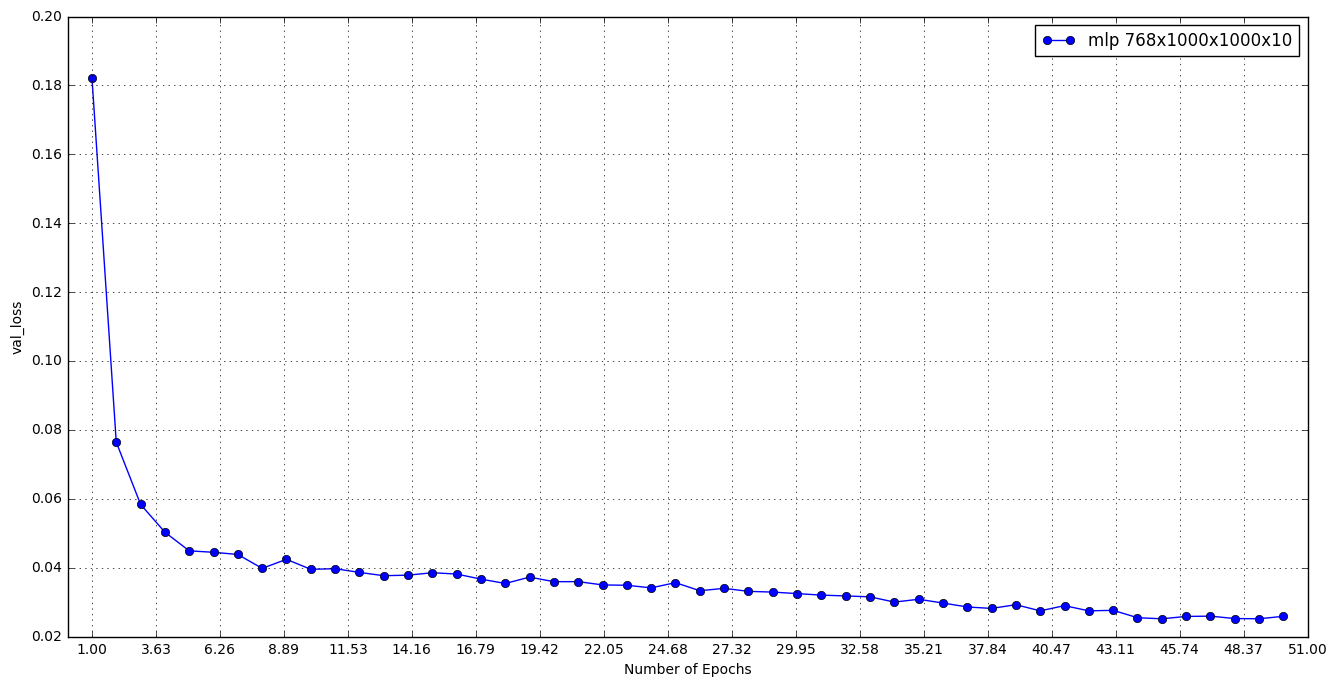

In [107]:
history_plot([history1], ['mlp 768x1000x1000x10'], n_epoch=50)

In [13]:
loss,acc = model1.evaluate(X_test, y_test, verbose=0)
print('Test loss: {0}'.format(loss)); print('Test accuracy: {0}'.format(acc))

Test loss: 0.030929651294089852
Test accuracy: 0.990139995765686


<div id='1.3b'/>
### Parte (b)

In [ ]:
## PARAMETERS
n_hidden_layer1 = 1000
activation_layer1 = 'sigmoid'; decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer1 = 'sigmoid'; decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

### AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(X_train, X_train, nb_epoch=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(X_val, X_val))

### AUTOENCODER 2
# FORWARD PASS DATA THROUGH FIRST ENCODER
X_train_encoded1 = encoder1.predict(X_train) 
X_val_encoded1 = encoder1.predict(X_val)
X_test_encoded1 = encoder1.predict(X_test)

input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(X_train_encoded1, X_train_encoded1, nb_epoch=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(X_val_encoded1, X_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add( Dense(n_hidden_layer2, activation=activation_layer2) )
model.layers[-1].set_weights( autoencoder2.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
# saving net before fine tunning
save_keras_model(model, 'mlp_768x1000x1000x10_pretrain_ae')
model.fit(X_train, y_train, nb_epoch=20, batch_size=25, shuffle=True, validation_data=(X_val, y_val))
# saving net after fine tunning
save_keras_model(model, 'mlp_768x1000x1000x10_finetunning_ae')

In [16]:
# Carga de history del modelo entrenado previamente
model20 = load(base_dir+'mlp_768x1000x1000x10_pretrain');
model21 = load(base_dir+'mlp_768x1000x1000x10_finetunning');
model20.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
model21.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history2 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_finetunning.hist', 'rb') )

Como puede verse del gráfico siguiente, el efecto de agregar un AE en el proceso de entrenamiento, sitúa a la MLP en un mejor punto de partida en el espacio de parámetros, esto es, el punto de partida se encuentra más cerca del conjunto de parámetros óptimos (locales), y por tanto puede alcanzar mejores soluciones con menor cantidad de epochs.

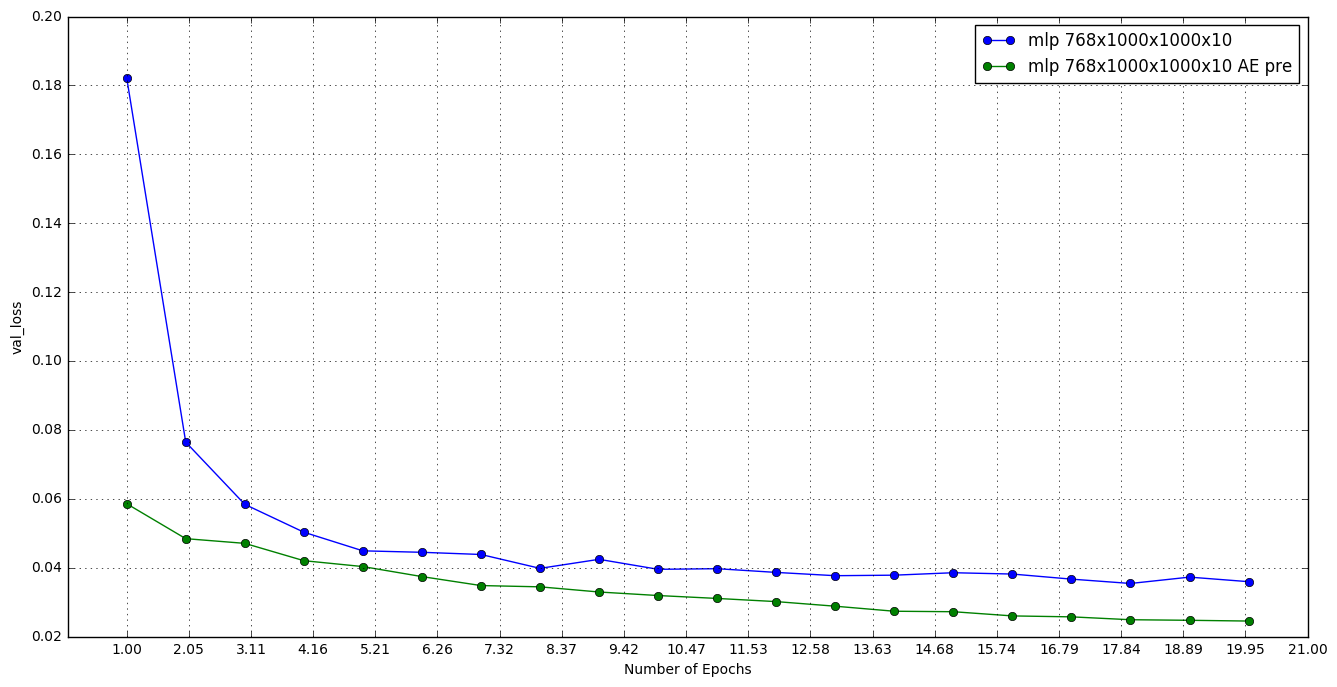

In [109]:
history_plot([history1, history2], ['mlp 768x1000x1000x10', 'mlp 768x1000x1000x10 AE pre'], n_epoch=20)

Se muestra a continuación el error sobre el conjunto de *test* para la red pre-entrenada y con *finetunning*. Se nota que el pre-entrenamiento produce una red con un `accuracy` bastante elevado. Por otro lado la *performance* después del *finetunning* es similar a la de la MLP convencional, sin embargo, la red pre-entrenada sólo se entrenó con $10$ *epochs* mientras que la MLP convencional realizó $50$ *epochs*.

In [18]:
loss,acc = model20.evaluate(X_test, y_test, verbose=0)
print('Pretrain results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model21.evaluate(X_test, y_test, verbose=0)
print('Finetunning results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

Pretrain results
Test loss: 0.3336046578884125
Test accuracy: 0.8999999761581421 

Finetunning results
Test loss: 0.02932350579686463
Test accuracy: 0.9903899961471557 



<div id='1.3c'/>
### Parte (c)

In [ ]:
### First RBM
rbm1 = BernoulliRBM(n_components=n_hidden_layer1, batch_size=25, learning_rate=0.05, verbose=1, n_iter=50)
rbm1.fit(X_train)
X_train_encoded1 = rbm1.transform(X_train)

### Second RBM
rbm2 = BernoulliRBM(n_components=n_hidden_layer2, batch_size=25, learning_rate=0.05, verbose=0, n_iter=50)
rbm2.fit(X_train_encoded1)

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( [rbm1.components_.T, rbm1.intercept_hidden_] )
model.add( Dense(n_hidden_layer2, activation=activation_layer2) )
model.layers[-1].set_weights( [rbm2.components_.T, rbm2.intercept_hidden_] )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
# saving net before fine tunning
save_keras_model(model, 'mlp_768x1000x1000x10_pretrain_rbm')
model.fit(X_train, y_train, nb_epoch=20, batch_size=25, shuffle=True, validation_data=(X_val, y_val))
# saving net after fine tunning
save_keras_model(model, 'mlp_768x1000x1000x10_finetunning_rbm')

In [19]:
# Carga de history del modelo entrenado previamente
model30 = load(base_dir+'mlp_768x1000x1000x10_pretrain_rbm');
model31 = load(base_dir+'mlp_768x1000x1000x10_finetunning_rbm');
model30.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
model31.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history3 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_finetunning_rbm.hist', 'rb') )

Los resultados que se muestran abajo, indican que el proceso de pre-entrenamiento realizado por la RBM es mejor que el que se obtuvo con el AE anterior: Deja al modelo en una mejor posición de partida, y permite alcanzar un menor error al terminar las 20 *epochs*.

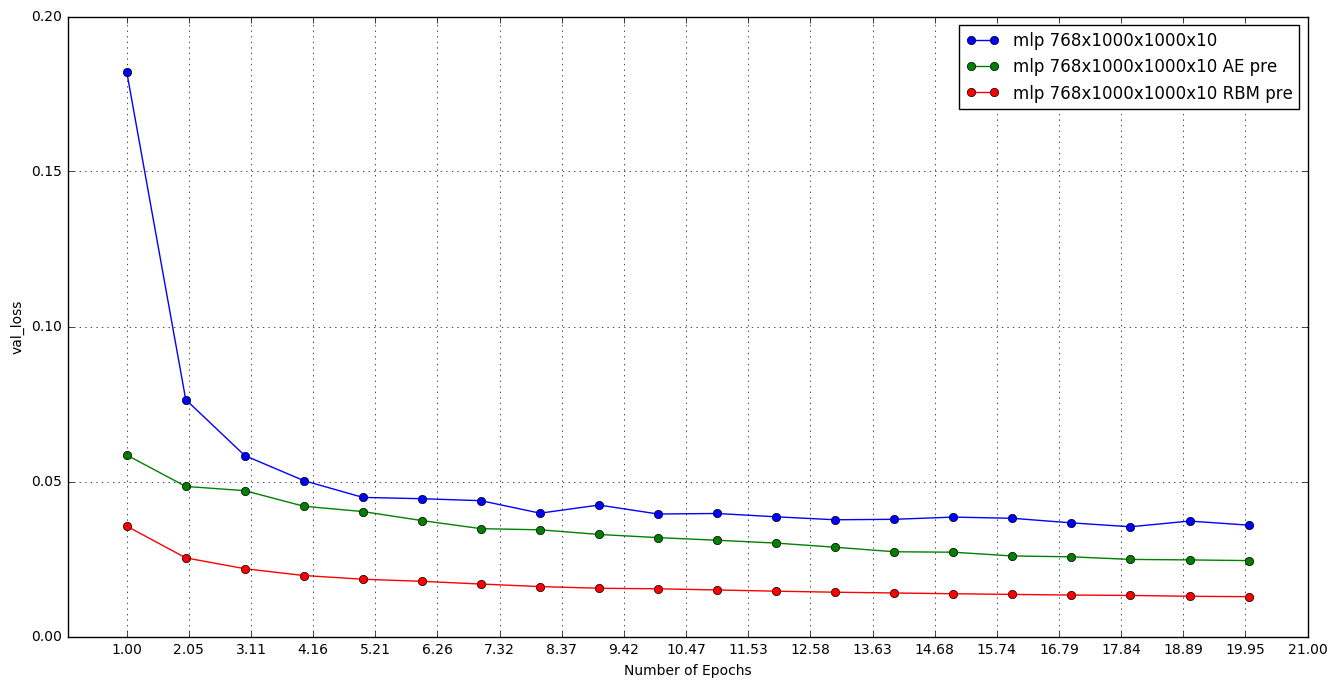

In [147]:
history_plot([history1, history2, history3], ['mlp 768x1000x1000x10', 
            'mlp 768x1000x1000x10 AE pre', 'mlp 768x1000x1000x10 RBM pre'], n_epoch=20)

En cuanto a `accuracy` sobre el conjunto de test, este también alcanza el mejor resultado hasta ahora. Reforzando entonces el resultado anterior, de que la RBM deja a la red en un buen punto de partida en el espacio de parámetros.

In [20]:
loss,acc = model30.evaluate(X_test, y_test, verbose=0)
print('Pretrain results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model31.evaluate(X_test, y_test, verbose=0)
print('Finetunning results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

Pretrain results
Test loss: 0.3256365779399872
Test accuracy: 0.8999999761581421 

Finetunning results
Test loss: 0.014466136141959577
Test accuracy: 0.9954299976348877 



<div id='1.3d'/>
### Parte (d)

Para esta parte, se ha decidido ocupar un dAE con ruido *gaussiano*, `devst=0.1` y funciones de activación sigmoidales, la cual fue una configuración que dio buenos resultados en secciones anteriores.

In [ ]:
# Data with gaussian noise
X_train_noisy, X_val_noisy, X_test_noisy = gaussian_noise(X_train, X_val, X_test)

### DENOISING AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(X_train_noisy, X_train, nb_epoch=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(X_val_noisy, X_val))

### DENOISING AUTOENCODER 2
# FORWARD PASS DATA THROUGH FIRST ENCODER
X_train_encoded1 = encoder1.predict(X_train) 
X_val_encoded1 = encoder1.predict(X_val)
X_test_encoded1 = encoder1.predict(X_test)
# adding gaussian noise also to encoded data
X_train_noisy_encoded1, X_val_noisy_encoded1, X_test_noisy_encoded1 = gaussian_noise(X_train_encoded1, X_val_encoded1,
                                                                                     X_test_encoded1)
input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(X_train_noisy_encoded1, X_train_encoded1, nb_epoch=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(X_val_noisy_encoded1, X_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add( Dense(n_hidden_layer2, activation=activation_layer2) )
model.layers[-1].set_weights( autoencoder2.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
# saving net before fine tunning
save_keras_model(model, 'mlp_768x1000x1000x10_pretrain_dae')
model.fit(X_train, y_train, nb_epoch=20, batch_size=25, shuffle=True, validation_data=(X_val, y_val))
# saving net after fine tunning
save_keras_model(model, 'mlp_768x1000x1000x10_finetunning_dae')

In [21]:
# Carga de history del modelo entrenado previamente
model40 = load(base_dir+'mlp_768x1000x1000x10_pretrain_dae');
model41 = load(base_dir+'mlp_768x1000x1000x10_finetunning_dae');
model40.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
model41.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history4 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_finetunning_dae.hist', 'rb') )

Los resultados siguientes muestran que el DAE no provee una mejora sustantiva a los resultados anteriores, sino que compite muy de cerca con los resultados del AE normal, pero de todos modos no logra superar el desempeño de la RBM.

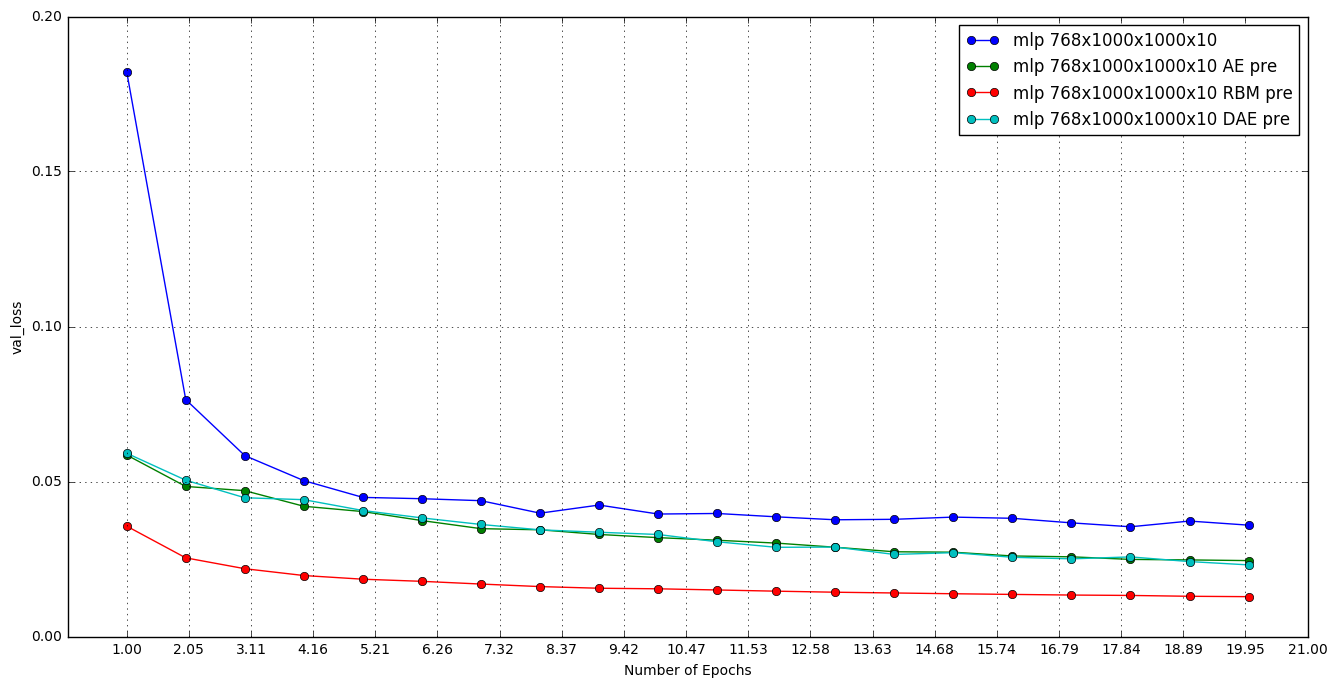

In [148]:
history_plot([history1, history2, history3, history4], ['mlp 768x1000x1000x10','mlp 768x1000x1000x10 AE pre', 
            'mlp 768x1000x1000x10 RBM pre', 'mlp 768x1000x1000x10 DAE pre'], n_epoch=20)

Los resultados sobre el conjunto de entrenamiento refuerzan la conclusión anterior.

In [22]:
loss,acc = model40.evaluate(X_test, y_test, verbose=0)
print('Pretrain results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model41.evaluate(X_test, y_test, verbose=0)
print('Finetunning results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

Pretrain results
Test loss: 0.3395186320781708
Test accuracy: 0.8999999761581421 

Finetunning results
Test loss: 0.029282233668118714
Test accuracy: 0.9903099973678589 



<div id='1.3e'/>
### Parte (e)

In [ ]:
## PARAMETERS
n_hidden_layer1 = 1000
activation_layer1 = 'sigmoid'; decoder_activation_1 = 'sigmoid'
n_hidden_layer2 = 1000
activation_layer1 = 'sigmoid'; decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

### AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer1, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(X_train, X_train, nb_epoch=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(X_val, X_val))

### AUTOENCODER 2
# FORWARD PASS DATA THROUGH FIRST ENCODER
X_train_encoded1 = encoder1.predict(X_train) 
X_val_encoded1 = encoder1.predict(X_val)
X_test_encoded1 = encoder1.predict(X_test)

input_img2 = Input(shape=(n_hidden_layer1,))
encoded2 = Dense(n_hidden_layer2, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer2, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(X_train_encoded1, X_train_encoded1, nb_epoch=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(X_val_encoded1, X_val_encoded1))
encoded_input2 = Input(shape=(n_hidden_layer2,))

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer1, activation=activation_layer1, input_shape=(784,), W_regularizer=l2(0.01)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add( Dense(n_hidden_layer2, activation=activation_layer2, W_regularizer=l2(0.01)) )
model.layers[-1].set_weights( autoencoder2.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
# saving net before fine tunning
save_keras_model(model, 'mlp_768x1000x1000x10_pretrain_ae')
model.fit(X_train, y_train, nb_epoch=20, batch_size=25, shuffle=True, validation_data=(X_val, y_val))
# saving net after fine tunning
save_keras_model(model, 'mlp_768x1000x1000x10_finetunning_ae')

In [23]:
# Carga de history del modelo entrenado previamente
model50 = load(base_dir+'mlp_768x1000x1000x10_pretrain_ae_reg')
model51 = load(base_dir+'mlp_768x1000x1000x10_finetunning_ae_reg')
model50.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
model51.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history5 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_finetunning_ae_reg.hist', 'rb') )

La red seleccionada para aplicar regularización es la MLP pre-entrenada con el AE de activaciones sigmoidales anterior. Como regularizador se ha elegido $l_2$. El gráfico siguiente compara el proceso de entrenamiento para ambas. Como puede verse el efecto del regularizado empeora enormemente los resultados. Esto puede deberse a un efecto muy fuerte de este último. Una posible solución es bajar el peso de este en la función objetivo a optimizar.

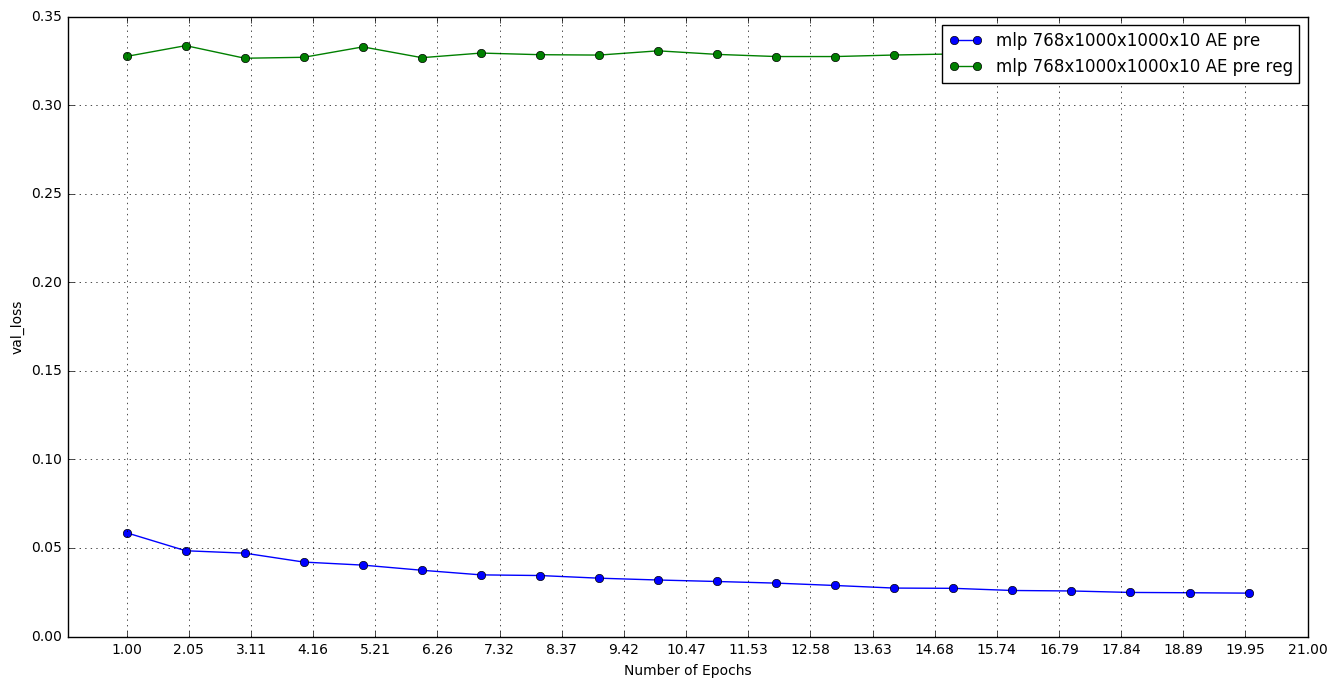

In [84]:
history_plot([history2, history5], ['mlp 768x1000x1000x10 AE pre', 'mlp 768x1000x1000x10 AE pre reg'], n_epoch=20)

Los resultados sobre el conjunto de entrenamiento refuerzan la conclusión anterior.

In [24]:
loss,acc = model50.evaluate(X_test, y_test, verbose=0)
print('Pretrain results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model51.evaluate(X_test, y_test, verbose=0)
print('Finetunning results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

Pretrain results
Test loss: 0.34366307444572447
Test accuracy: 0.8999999761581421 

Finetunning results
Test loss: 0.3268149789810181
Test accuracy: 0.8999999761581421 



<div id='1.3f'/>
### Parte (f)

### `MLP` (clásica) con distintas activaciones

In [25]:
# Carga de history del modelo entrenado previamente
model6 = load(base_dir+'mlp_768x1000x1000x10_relu')
model6.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history6 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_relu.hist', 'rb') )

model7 = load(base_dir+'mlp_768x1000x1000x10_tanh')
model7.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history7 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_tanh.hist', 'rb') )

Los resultados de a continuación muestran que el desempeño de la MLP con `relu` y `tanh` es superior al obtenido por las otras. En particular con activaciones `sigmoid` el error decrece muy lentamente, lo cual es una expresión del fenómeno de `vanishing gradients` conocido de esta configuración.

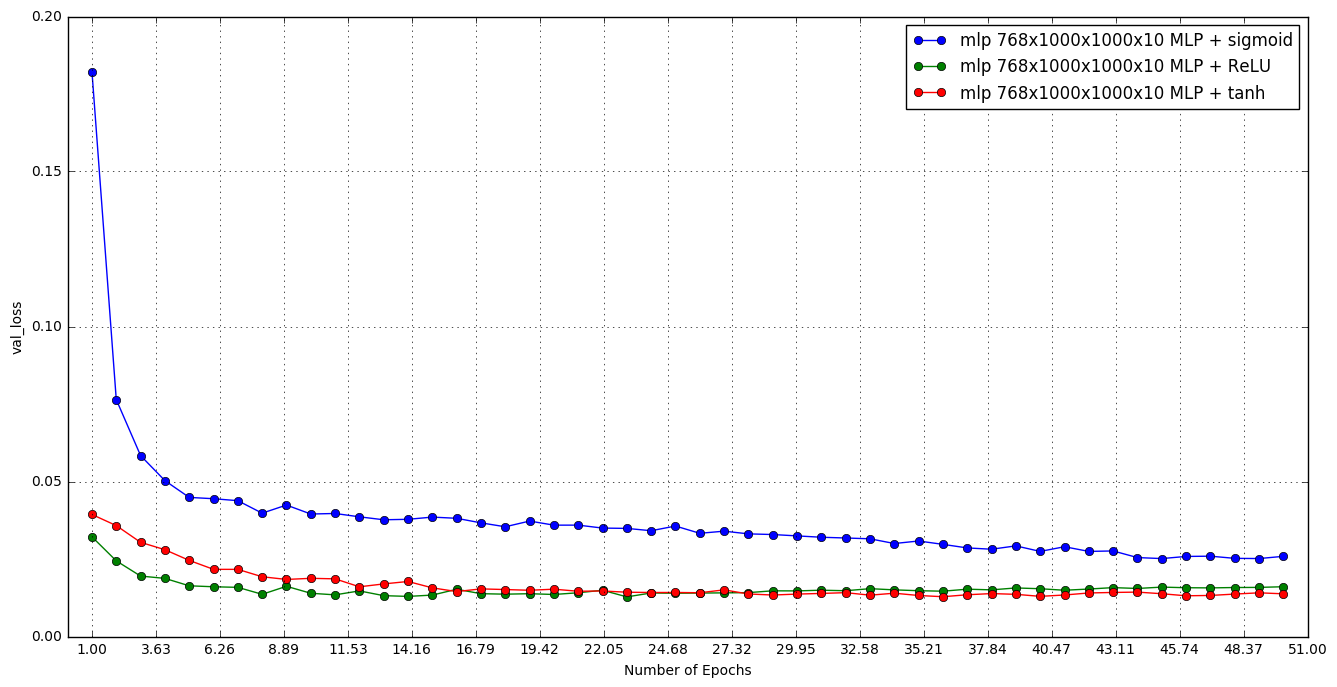

In [86]:
history_plot([history1, history6, history7], ['mlp 768x1000x1000x10 MLP + sigmoid',
            'mlp 768x1000x1000x10 MLP + ReLU', 'mlp 768x1000x1000x10 MLP + tanh'], n_epoch=50)

Los resultados sobre el conjunto de entrenamiento son los mejores vistos hasta ahora (Es ligeramente mejor el de ReLU). Por otro lado, recordar que la MLP convencional se está entrenando con $50$ *epochs*, mientras que las redes pre-entrenadas sólo utilizan $10$ *epochs*.

In [26]:
loss,acc = model6.evaluate(X_test, y_test, verbose=0)
print('ReLU results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model7.evaluate(X_test, y_test, verbose=0)
print('Tanh results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

ReLU results
Test loss: 0.011682761193952501
Test accuracy: 0.9964599956512451 

Tanh results
Test loss: 0.011347551679700701
Test accuracy: 0.9962699954986572 



### `MLP + AE pre-training` con distintas activaciones

In [27]:
# Carga de history del modelo entrenado previamente
model8 = load(base_dir+'mlp_768x1000x1000x10_finetunning_relu')
model8.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history8 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_finetunning_relu.hist', 'rb') )

model9 = load(base_dir+'mlp_768x1000x1000x10_finetunning_tanh')
model9.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history9 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_finetunning_tanh.hist', 'rb') )

A diferencia de lo que se podría esperar, `relu` no tiene un resultado sustancialmente mejor que el obtenido con `sigmoid`. Por otro lado, `tanh` muestra una mejora significativa, tanto en el proceso de pre-entrenamiento, como en el entrenamiento (*finetunning*) del MLP.

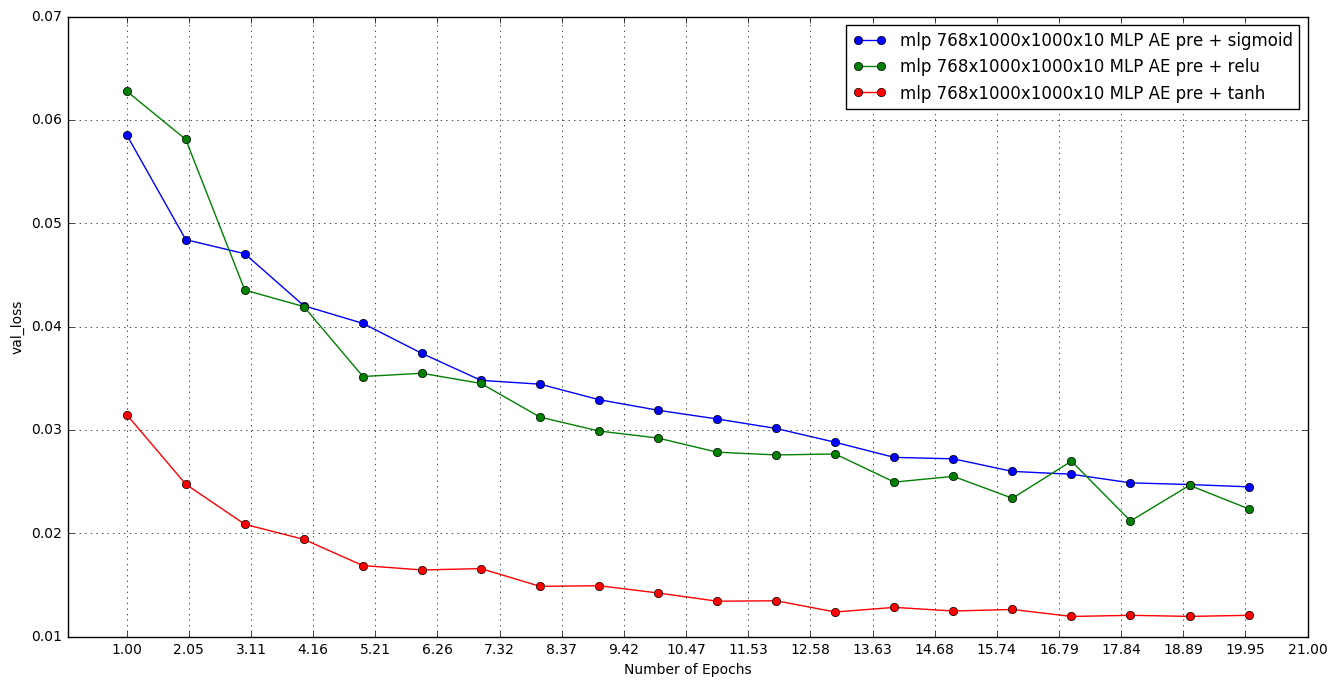

In [88]:
history_plot([history2, history8, history9], ['mlp 768x1000x1000x10 MLP AE pre + sigmoid', 
            'mlp 768x1000x1000x10 MLP AE pre + relu', 'mlp 768x1000x1000x10 MLP AE pre + tanh'], n_epoch=20)

Se corrobora también sobre el conjunto de entrenamiento, el buen desempeño que tiene la función `tanh` en la configuración con pre-entrenamiento, alcanzando la `accuracy` más alta en las redes con pre-entrenamiento.

In [28]:
loss,acc = model8.evaluate(X_test, y_test, verbose=0)
print('ReLU results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model9.evaluate(X_test, y_test, verbose=0)
print('Tanh results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

ReLU results
Test loss: 0.02487821425013244
Test accuracy: 0.9918799962043762 

Tanh results
Test loss: 0.010894658477493794
Test accuracy: 0.9964399950027466 



### `MLP + RBM pre-training` con distintas activaciones

In [29]:
# Carga de history del modelo entrenado previamente
model10 = load(base_dir+'mlp_768x1000x1000x10_finetunning_rbm_relu')
model10.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history10 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_finetunning_rbm_relu.hist', 'rb') )

model11 = load(base_dir+'mlp_768x1000x1000x10_finetunning_rbm_tanh')
model11.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history11 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_finetunning_rbm_tanh.hist', 'rb') )

Los resultados de a continuación muestran que para esta configuración, la RBM deja en un mal punto de partida a la MLP con activaciones `relu`, no pudiendo mejorar su resultado.

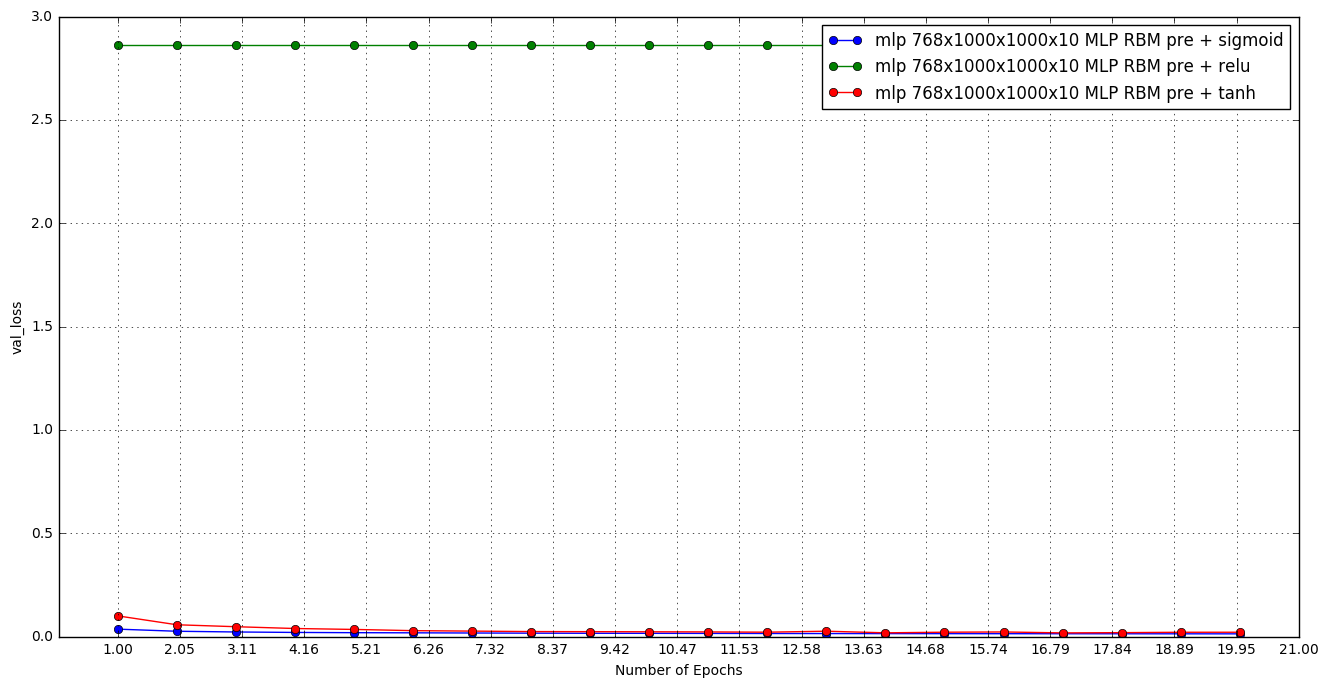

In [104]:
history_plot([history3, history10, history11], ['mlp 768x1000x1000x10 MLP RBM pre + sigmoid',
            'mlp 768x1000x1000x10 MLP RBM pre + relu', 'mlp 768x1000x1000x10 MLP RBM pre + tanh'], n_epoch=20)

Omitiendo ahora el resultado con `relu` (para mejor visualización), se observa que el mejor resultado para esta configuración se obtiene con activación `sigmoid` en vez de `tanh`.

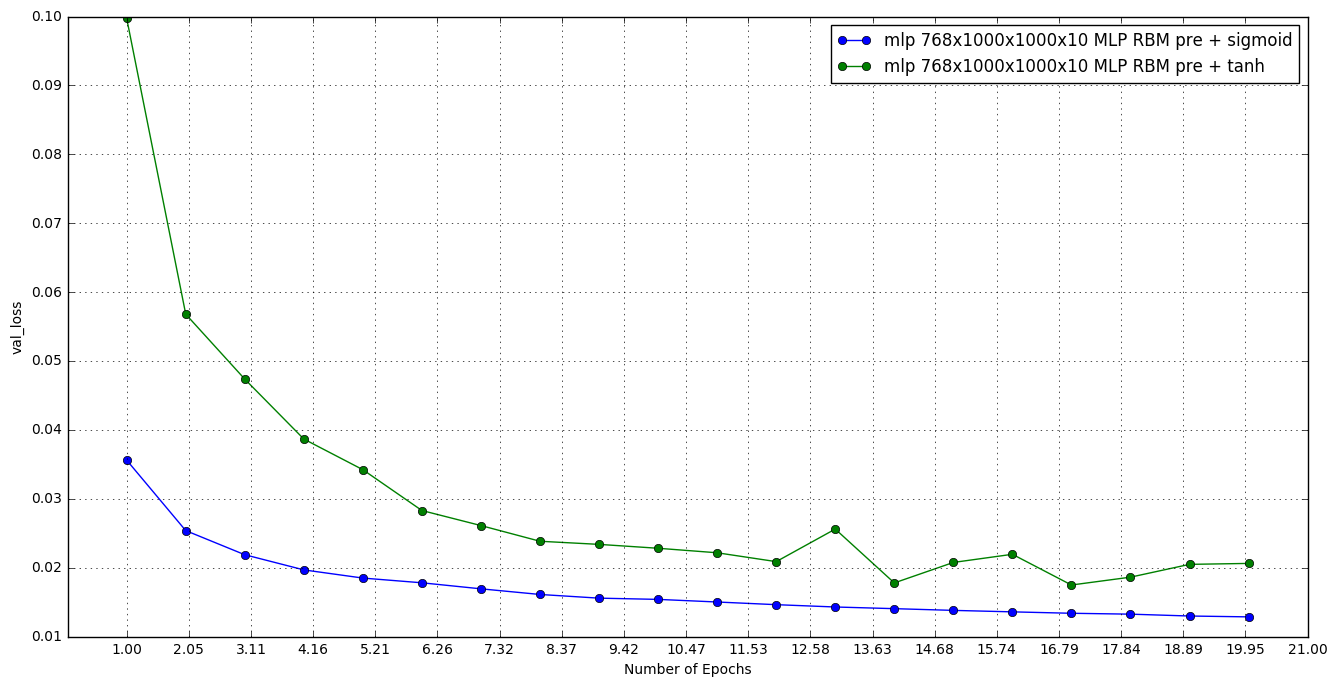

In [149]:
# sin relu
history_plot([history3, history11], ['mlp 768x1000x1000x10 MLP RBM pre + sigmoid',
            'mlp 768x1000x1000x10 MLP RBM pre + tanh'], n_epoch=20)

Los resultados sobre el conjunto de entrenamiento están acordes a los resultados anteriores. 

In [30]:
loss,acc = model10.evaluate(X_test, y_test, verbose=0)
print('ReLU results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model11.evaluate(X_test, y_test, verbose=0)
print('Tanh results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

ReLU results
Test loss: 2.8989088516235353
Test accuracy: 0.8191600031852723 

Tanh results
Test loss: 0.019809836004674435
Test accuracy: 0.9937499959945679 



### `MLP + DAE pre` con distintas activaciones

In [31]:
# Carga de history del modelo entrenado previamente
model12 = load(base_dir+'mlp_768x1000x1000x10_finetunning_dae_relu')
model12.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history12 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_finetunning_dae_relu.hist', 'rb') )

model13 = load(base_dir+'mlp_768x1000x1000x10_finetunning_dae_tanh')
model13.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history13 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_finetunning_dae_tanh.hist', 'rb') )

Para esta última configuración (Pre-entrenamiento con DAE), el resultado es similar al obtenido con pre-entrenamiento con AE: La red con mejor desempeño tanto en pre-entrenamiento como en entrenamiento, es la con activaciones `tanh`, seguida por red con activaciones `relu`.

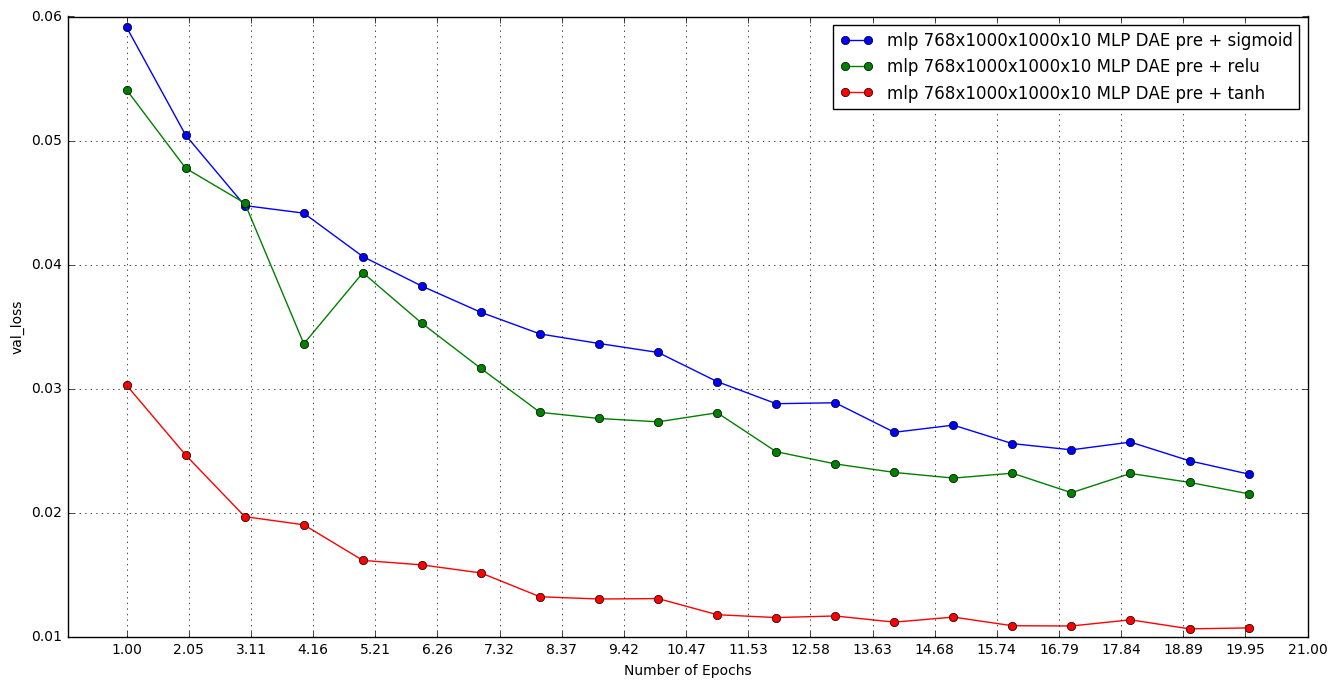

In [92]:
history_plot([history4, history12, history13], ['mlp 768x1000x1000x10 MLP DAE pre + sigmoid',
            'mlp 768x1000x1000x10 MLP DAE pre + relu', 'mlp 768x1000x1000x10 MLP DAE pre + tanh'], n_epoch=20)

Los resultados sobre el conjunto de entrenamiento están acordes a los resultados anteriores.

In [33]:
loss,acc = model12.evaluate(X_test, y_test, verbose=0)
print('ReLU results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model13.evaluate(X_test, y_test, verbose=0)
print('Tanh results'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

ReLU results
Test loss: 0.02568165319273248
Test accuracy: 0.9914199974060058 

Tanh results
Test loss: 0.011926016186346533
Test accuracy: 0.9956899967193603 



<div id='1.3g'/>
### Parte (g)

En esta sección se compara el efecto de cambiar la cantidad de neuronas de la capa oculta, dejando fijo el número de layers `L=3`. La configuración de red elegida para trabajar, es una de las que obtuvo los mejores resultados (y más estables) de las secciones anteriores: `MLP + AE pretraining + tanh`.

In [ ]:
## PARAMETERS
n_hidden_layer = 500
activation_layer1 = 'tanh'; decoder_activation_1 = 'sigmoid'
activation_layer2 = 'tanh'; decoder_activation_2 = 'sigmoid'
activation_layer3 = 'tanh'; decoder_activation_3 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

### AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(X_train, X_train, nb_epoch=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(X_val, X_val))

### AUTOENCODER 2
# FORWARD PASS DATA THROUGH FIRST ENCODER
X_train_encoded1 = encoder1.predict(X_train) 
X_val_encoded1 = encoder1.predict(X_val)
X_test_encoded1 = encoder1.predict(X_test)

input_img2 = Input(shape=(n_hidden_layer,))
encoded2 = Dense(n_hidden_layer, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(X_train_encoded1, X_train_encoded1, nb_epoch=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(X_val_encoded1, X_val_encoded1))

### AUTOENCODER 3
# FORWARD PASS DATA THROUGH FIRST ENCODER
X_train_encoded2 = encoder2.predict(X_train_encoded1) 
X_val_encoded2 = encoder2.predict(X_val_encoded1)
X_test_encoded2 = encoder2.predict(X_test_encoded1)

input_img3 = Input(shape=(n_hidden_layer,))
encoded3 = Dense(n_hidden_layer, activation=activation_layer3)(input_img3)
decoded3 = Dense(n_hidden_layer, activation=decoder_activation_3)(encoded3)
autoencoder3 = Model(input=input_img3, output=decoded3)
encoder3 = Model(input=input_img3, output=encoded3)
autoencoder3.compile(optimizer=optimizer_, loss=loss_)
autoencoder3.fit(X_train_encoded2, X_train_encoded2, nb_epoch=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(X_val_encoded2, X_val_encoded2))

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add( Dense(n_hidden_layer, activation=activation_layer2) )
model.layers[-1].set_weights( autoencoder2.layers[1].get_weights() )
model.add( Dense(n_hidden_layer, activation=activation_layer3) )
model.layers[-1].set_weights( autoencoder3.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
# saving net before fine tunning
save_keras_model(model, 'mlp_768x{0}x{0}x{0}x10_pretrain_ae_tanh'.format(n_hidden_layer))
model.fit(X_train, y_train, nb_epoch=20, batch_size=25, shuffle=True, validation_data=(X_val, y_val))
# saving net after fine tunning
save_keras_model(model, 'mlp_768x{0}x{0}x{0}x10_finetunning_ae_tanh'.format(n_hidden_layer))

In [34]:
# Carga de history del modelo entrenado previamente
model15 = load(base_dir+'mlp_768x500x500x500x10_finetunning_ae_tanh')
model15.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history15 = pickle.load( open(base_dir+'mlp_768x500x500x500x10_finetunning_ae_tanh.hist', 'rb') )

model16 = load(base_dir+'mlp_768x1000x1000x1000x10_finetunning_ae_tanh')
model16.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history16 = pickle.load( open(base_dir+'mlp_768x1000x1000x1000x10_finetunning_ae_tanh.hist', 'rb') )

model17 = load(base_dir+'mlp_768x2000x2000x2000x10_finetunning_ae_tanh')
model17.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history17 = pickle.load( open(base_dir+'mlp_768x2000x2000x2000x10_finetunning_ae_tanh.hist', 'rb') )

model18 = load(base_dir+'mlp_768x4000x4000x4000x10_finetunning_ae_tanh')
model18.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history18 = pickle.load( open(base_dir+'mlp_768x4000x4000x4000x10_finetunning_ae_tanh.hist', 'rb') )

Efectivamente al aumentar el número de neuronas de la capa escondida, comienzan a aumentar las capacidades de las redes (esto se observa en el cambio de `500` en adelante). Sin embargo para una cantidad muy alta (`4000` por ejemplo) no está aportando en nada, es más, dado que la cantidad de parámetros para este caso es enorme, da la posibilidad de que se caiga en *overfitting*. Como conclusión, la cantidad de neuronas en la capa oculta debe ser un número intermedio de modo tal que la red tenga una buena capacidad de aprendizaje, pero que se tenga controlado el *overfitting*.

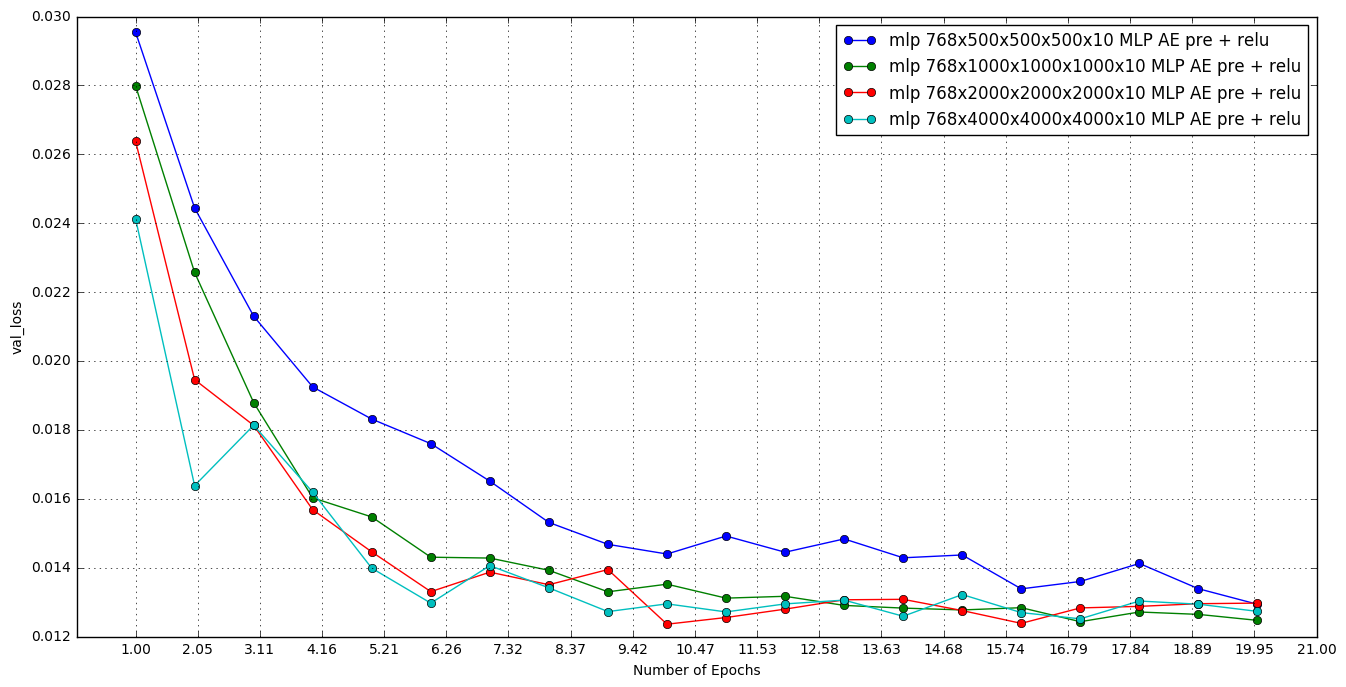

In [99]:
history_plot([history15, history16, history17, history18], ['mlp 768x500x500x500x10 MLP AE pre + tanh',
            'mlp 768x1000x1000x1000x10 MLP AE pre + tanh', 'mlp 768x2000x2000x2000x10 MLP AE pre + tanh',
            'mlp 768x4000x4000x4000x10 MLP AE pre + tanh'], n_epoch=20)

Los resultado sobre el conjunto de entrenamiento refuerzan la idea anterior: La configuración que alcanzó el mayor `accuracy` es la con $2000$ unidades ocultas y no la con $4000$ (pese a que la diferencia es muy baja).

In [37]:
loss,acc = model15.evaluate(X_test, y_test, verbose=0)
print('500 hidden units'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model16.evaluate(X_test, y_test, verbose=0)
print('1000 hidden units'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model17.evaluate(X_test, y_test, verbose=0)
print('2000 hidden units'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model18.evaluate(X_test, y_test, verbose=0)
print('4000 hidden units'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

500 hidden units
Test loss: 0.013001461930008373
Test accuracy: 0.9956399961471558 

1000 hidden units
Test loss: 0.012807100528641605
Test accuracy: 0.9953299961090087 

2000 hidden units
Test loss: 0.010982110825739074
Test accuracy: 0.9962299962997436 

4000 hidden units
Test loss: 0.01099386191250669
Test accuracy: 0.9961999954223633 



<div id='1.2h'/>
### Parte (h)

En esta sección se realiza el proceso inverso al anterior; Se mantiene fijo el número de neuronas de la capa oculta (`1000`) y se va aumentando el número de capas (`L` $\in [1,2,3]$). La configuración de red utilizada es la misma: `MLP + AE pretraining + tanh`.

### Nivel de profundidad `L=1`

In [ ]:
## PARAMETERS
n_hidden_layer = 1000
activation_layer1 = 'tanh'; decoder_activation_1 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

### AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(X_train, X_train, nb_epoch=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(X_val, X_val))

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
# saving net before fine tunning
save_keras_model(model, 'mlp_768x{0}x10_pretrain_ae_tanh'.format(n_hidden_layer))
model.fit(X_train, y_train, nb_epoch=20, batch_size=25, shuffle=True, validation_data=(X_val, y_val))
# saving net after fine tunning
save_keras_model(model, 'mlp_768x{0}x10_finetunning_ae_tanh'.format(n_hidden_layer))

### Nivel de profundidad `L=2`

In [ ]:
## PARAMETERS
n_hidden_layer = 1000
activation_layer1 = 'tanh'; decoder_activation_1 = 'sigmoid'
activation_layer2 = 'tanh'; decoder_activation_2 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

### AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(X_train, X_train, nb_epoch=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(X_val, X_val))

### AUTOENCODER 2
# FORWARD PASS DATA THROUGH FIRST ENCODER
X_train_encoded1 = encoder1.predict(X_train) 
X_val_encoded1 = encoder1.predict(X_val)
X_test_encoded1 = encoder1.predict(X_test)

input_img2 = Input(shape=(n_hidden_layer,))
encoded2 = Dense(n_hidden_layer, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(X_train_encoded1, X_train_encoded1, nb_epoch=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(X_val_encoded1, X_val_encoded1))

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add( Dense(n_hidden_layer, activation=activation_layer2) )
model.layers[-1].set_weights( autoencoder2.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
# saving net before fine tunning
save_keras_model(model, 'mlp_768x{0}x{0}x10_pretrain_ae_tanh'.format(n_hidden_layer))
model.fit(X_train, y_train, nb_epoch=20, batch_size=25, shuffle=True, validation_data=(X_val, y_val))
# saving net after fine tunning
save_keras_model(model, 'mlp_768x{0}x{0}x10_finetunning_ae_tanh'.format(n_hidden_layer))

### Nivel de profundidad `L=3`

In [ ]:
## PARAMETERS
n_hidden_layer = 1000
activation_layer1 = 'tanh'; decoder_activation_1 = 'sigmoid'
activation_layer2 = 'tanh'; decoder_activation_2 = 'sigmoid'
activation_layer3 = 'tanh'; decoder_activation_3 = 'sigmoid'
loss_ = 'binary_crossentropy'
optimizer_ = SGD(lr=1.0)
epochs_ = 50
batch_size_ = 25

### AUTOENCODER 1
input_img1 = Input(shape=(784,))
encoded1 = Dense(n_hidden_layer, activation=activation_layer1)(input_img1)
decoded1 = Dense(784, activation=decoder_activation_1)(encoded1)
autoencoder1 = Model(input=input_img1, output=decoded1)
encoder1 = Model(input=input_img1, output=encoded1)
autoencoder1.compile(optimizer=optimizer_, loss=loss_)
autoencoder1.fit(X_train, X_train, nb_epoch=epochs_, batch_size=batch_size_, 
                 shuffle=True, validation_data=(X_val, X_val))

### AUTOENCODER 2
# FORWARD PASS DATA THROUGH FIRST ENCODER
X_train_encoded1 = encoder1.predict(X_train) 
X_val_encoded1 = encoder1.predict(X_val)
X_test_encoded1 = encoder1.predict(X_test)

input_img2 = Input(shape=(n_hidden_layer,))
encoded2 = Dense(n_hidden_layer, activation=activation_layer2)(input_img2)
decoded2 = Dense(n_hidden_layer, activation=decoder_activation_2)(encoded2)
autoencoder2 = Model(input=input_img2, output=decoded2)
encoder2 = Model(input=input_img2, output=encoded2)
autoencoder2.compile(optimizer=optimizer_, loss=loss_)
autoencoder2.fit(X_train_encoded1, X_train_encoded1, nb_epoch=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(X_val_encoded1, X_val_encoded1))

### AUTOENCODER 3
# FORWARD PASS DATA THROUGH FIRST ENCODER
X_train_encoded2 = encoder2.predict(X_train_encoded1) 
X_val_encoded2 = encoder2.predict(X_val_encoded1)
X_test_encoded2 = encoder2.predict(X_test_encoded1)

input_img3 = Input(shape=(n_hidden_layer,))
encoded3 = Dense(n_hidden_layer, activation=activation_layer3)(input_img3)
decoded3 = Dense(n_hidden_layer, activation=decoder_activation_3)(encoded3)
autoencoder3 = Model(input=input_img3, output=decoded3)
encoder3 = Model(input=input_img3, output=encoded3)
autoencoder3.compile(optimizer=optimizer_, loss=loss_)
autoencoder3.fit(X_train_encoded2, X_train_encoded2, nb_epoch=epochs_, batch_size=batch_size_,
                 shuffle=True, validation_data=(X_val_encoded2, X_val_encoded2))

### FINE TUNNING
model = Sequential()
model.add( Dense(n_hidden_layer, activation=activation_layer1, input_shape=(784,)) )
model.layers[-1].set_weights( autoencoder1.layers[1].get_weights() )
model.add( Dense(n_hidden_layer, activation=activation_layer2) )
model.layers[-1].set_weights( autoencoder2.layers[1].get_weights() )
model.add( Dense(n_hidden_layer, activation=activation_layer3) )
model.layers[-1].set_weights( autoencoder3.layers[1].get_weights() )
model.add(Dense(10, activation='softmax'))
model.compile(optimizer=optimizer_, loss='binary_crossentropy', metrics=['accuracy'])
# saving net before fine tunning
save_keras_model(model, 'mlp_768x{0}x{0}x{0}x10_pretrain_ae_tanh'.format(n_hidden_layer))
model.fit(X_train, y_train, nb_epoch=20, batch_size=25, shuffle=True, validation_data=(X_val, y_val))
# saving net after fine tunning
save_keras_model(model, 'mlp_768x{0}x{0}x{0}x10_finetunning_ae_tanh'.format(n_hidden_layer))

#### Sumario de resultados

In [41]:
# Carga de history del modelo entrenado previamente
model20 = load(base_dir+'mlp_768x1000x10_finetunning_ae_tanh')
model20.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history20 = pickle.load( open(base_dir+'mlp_768x1000x10_finetunning_ae_tanh.hist', 'rb') )

model21 = load(base_dir+'mlp_768x1000x1000x10_finetunning_ae_tanh')
model21.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history21 = pickle.load( open(base_dir+'mlp_768x1000x1000x10_finetunning_ae_tanh.hist', 'rb') )

model22 = load(base_dir+'mlp_768x1000x1000x1000x10_finetunning_ae_tanh')
model22.compile(optimizer=SGD(lr=1.0), loss='binary_crossentropy', metrics=['accuracy'])
history22 = pickle.load( open(base_dir+'mlp_768x1000x1000x1000x10_finetunning_ae_tanh.hist', 'rb') )

En base a los resultado que se muestran a continuación, se observa que con un sólo nivel de profundidad los errores que se obtienen son mayores a los de las otras dos configuraciones.


Por otro lado, la configuración con mejor desempeño fue con dos capas ocultas `L=2` y no con `L=3`. Si se observan estas dos últimas, ambas tiene un punto de partida similar. Se concluye entonces que la red con `L=2` permite un mejor flujo del gradiente, y por lo mismo logra disminuir su error de forma más rápida.

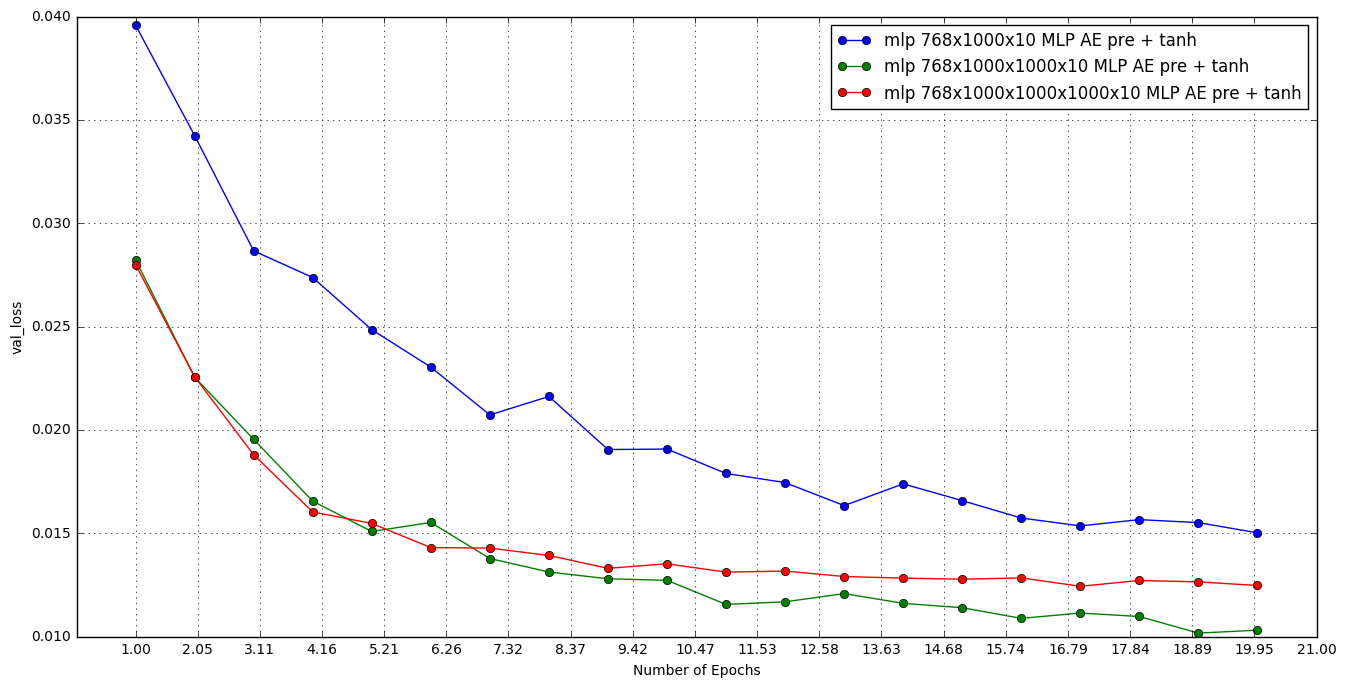

In [102]:
history_plot([history20, history21, history22], ['mlp 768x1000x10 MLP AE pre + tanh',
            'mlp 768x1000x1000x10 MLP AE pre + tanh', 'mlp 768x1000x1000x1000x10 MLP AE pre + tanh'], n_epoch=20)

Los resultados sobre el conjunto de prueba está de acuerdo a las conclusiones anteriores: La configuración con mejor desempeño es la con dos capas ocultas `L=2`.

In [42]:
loss,acc = model20.evaluate(X_test, y_test, verbose=0)
print('1 hidden layers'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model21.evaluate(X_test, y_test, verbose=0)
print('2 hidden layers'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))
loss,acc = model22.evaluate(X_test, y_test, verbose=0)
print('3 hidden layers'); print('Test loss: {0}'.format(loss)); print('Test accuracy: {0} \n'.format(acc))

1 hidden layers
Test loss: 0.015220919461548328
Test accuracy: 0.9950899955749511 

2 hidden layers
Test loss: 0.011172970943682595
Test accuracy: 0.9960599948883057 

3 hidden layers
Test loss: 0.012807100528641605
Test accuracy: 0.9953299961090087 

